In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna

In [4]:
!pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.4.0
    Uninstalling lightgbm-4.4.0:
      Successfully uninstalled lightgbm-4.4.0


In [3]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping
from sklearn.metrics import r2_score
import joblib  # For saving and loading models
%matplotlib inline

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
file_path = '/content/drive/MyDrive/practce/MOCK_DATA.csv'  # 실제 파일 경로로 변경 필요
data = pd.read_csv(file_path, encoding='cp949')
data.head()

,date,time,1f_1_cong,1f_but_cong,2f_he_cong,2f_2_cong,1f_1_cong_ratio,1f_but_cong_ratio,2f_he_cong_ratio,2f_2_cong_ratio
0,3/10/2024,17:25,43,11,25,11,10.49%,7.05%,13.37%,3.37%
1,6/10/2024,19:30,22,7,52,2,5.37%,4.49%,27.81%,0.61%
2,5/26/2024,10:18,13,29,30,4,3.17%,18.59%,16.04%,1.23%
3,4/5/2024,23:57,38,30,52,21,9.27%,19.23%,27.81%,6.44%
4,6/2/2024,5:38,8,9,22,19,1.95%,5.77%,11.76%,5.83%


In [5]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

# datetime에서 유용한 특징 추출 (연, 월, 일, 시간, 요일 등)
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek

data.head()

,date,time,1f_1_cong,1f_but_cong,2f_he_cong,2f_2_cong,1f_1_cong_ratio,1f_but_cong_ratio,2f_he_cong_ratio,2f_2_cong_ratio,datetime,year,month,day,hour,dayofweek
0,3/10/2024,17:25,43,11,25,11,10.49%,7.05%,13.37%,3.37%,2024-03-10 17:25:00,2024,3,10,17,6
1,6/10/2024,19:30,22,7,52,2,5.37%,4.49%,27.81%,0.61%,2024-06-10 19:30:00,2024,6,10,19,0
2,5/26/2024,10:18,13,29,30,4,3.17%,18.59%,16.04%,1.23%,2024-05-26 10:18:00,2024,5,26,10,6
3,4/5/2024,23:57,38,30,52,21,9.27%,19.23%,27.81%,6.44%,2024-04-05 23:57:00,2024,4,5,23,4
4,6/2/2024,5:38,8,9,22,19,1.95%,5.77%,11.76%,5.83%,2024-06-02 05:38:00,2024,6,2,5,6


In [6]:
# 필요없는 열 제거
data = data.drop(['date', 'time', 'datetime', '1f_1_cong_ratio', '1f_but_cong_ratio',	'2f_he_cong_ratio',	'2f_2_cong_ratio'], axis=1)

data.head()

,1f_1_cong,1f_but_cong,2f_he_cong,2f_2_cong,year,month,day,hour,dayofweek
0,43,11,25,11,2024,3,10,17,6
1,22,7,52,2,2024,6,10,19,0
2,13,29,30,4,2024,5,26,10,6
3,38,30,52,21,2024,4,5,23,4
4,8,9,22,19,2024,6,2,5,6


In [7]:
print(data.columns)

Index(['1f_1_cong', '1f_but_cong', '2f_he_cong', '2f_2_cong', 'year', 'month',
       'day', 'hour', 'dayofweek'],
      dtype='object')


In [10]:
X = data[['year', 'month', 'day', 'hour', 'dayofweek']]
target_columns = ['1f_1_cong', '1f_but_cong', '2f_he_cong', '2f_2_cong']

# 예측 데이터
future_data = pd.DataFrame({
    'date': ['4/10/2025'],
    'time': ['18:30'],
})

future_data['datetime'] = pd.to_datetime(future_data['date'] + ' ' + future_data['time'])
future_data['year'] = future_data['datetime'].dt.year
future_data['month'] = future_data['datetime'].dt.month
future_data['day'] = future_data['datetime'].dt.day
future_data['hour'] = future_data['datetime'].dt.hour
future_data['dayofweek'] = future_data['datetime'].dt.dayofweek
future_X = future_data[['year', 'month', 'day', 'hour', 'dayofweek']]

# 모델 학습
def train_and_evaluate_model(target_column):
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #파라미터 튜닝
    def objective(trial):
        param = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1),
        }

        # LightGBM 모델 학습
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                  early_stopping_rounds=100, verbose=False)

        # 예측 및 성능
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        return r2

    # Optuna로 하이퍼 파라미터 최적화
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    # 최적 파라미터 출력
    best_params = study.best_params
    print(f"Best params for {target_column}: {best_params}")

    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train)

    model_filename = f"{target_column}_model.pkl"
    joblib.dump(model, "/content/drive/MyDrive/practce/" + model_filename)
    print(f"saved as /content/drive/MyDrive/practce/ +{model_filename}")

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    r2 = r2_score(y_test, y_pred)
    print(f"{target_column} - Test R² score: {r2}")

    # 실험
    future_prediction = model.predict(future_X)
    print(f"Future prediction for {target_column}: {future_prediction[0]}")

    return future_prediction[0]

# 네 가지 열람실에 대해 모델 훈련 및 예측
future_predictions = {}
for target_column in target_columns:
    print(f"Training model for {target_column}")
    future_predictions[target_column] = train_and_evaluate_model(target_column)

# 예측 결과 출력
print("\nFuture predictions for each model:")
for target_column, prediction in future_predictions.items():
    print(f"{target_column}: Future prediction = {prediction}")

def load_and_predict(target_column, future_X):
    model_filename = "/content/drive/MyDrive/practce/" + f"{target_column}_model.pkl"
    model = joblib.load(model_filename)
    prediction = model.predict(future_X)
    print(f"Loaded model for {target_column} predicts: {prediction[0]}")

print("\nLoading models and making predictions:")
for target_column in target_columns:
    load_and_predict(target_column, future_X)

[I 2024-08-20 01:28:59,497] A new study created in memory with name: no-name-00d1f1de-57d9-4486-ad6a-495be6cc8c08


Training model for 1f_1_cong
[LightGBM] [Warning] feature_fraction is set=0.524777613152074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524777613152074
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.355018569183475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.355018569183475
[LightGBM] [Warning] bagging_fraction is set=0.627394336846897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.627394336846897
[LightGBM] [Warning] lambda_l1 is set=6.785144323884964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.785144323884964


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:28:59,763] Trial 0 finished with value: 0.21504103079899828 and parameters: {'lambda_l1': 6.785144323884964, 'lambda_l2': 4.355018569183475, 'num_leaves': 36, 'feature_fraction': 0.524777613152074, 'bagging_fraction': 0.627394336846897, 'bagging_freq': 6, 'min_child_samples': 84, 'lea

[LightGBM] [Warning] feature_fraction is set=0.9022120932662794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9022120932662794
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.6466246950711585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6466246950711585
[LightGBM] [Warning] bagging_fraction is set=0.49394215501391936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49394215501391936
[LightGBM] [Warning] lambda_l1 is set=6.017848743220264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.017848743220264
[LightGBM] [Warning] feature_fraction is set=0.6692785442798259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6692785442798259
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.915727651432277, reg_l

[I 2024-08-20 01:29:00,033] Trial 3 finished with value: 0.44679129244116245 and parameters: {'lambda_l1': 5.126618466780762, 'lambda_l2': 8.87251376875306, 'num_leaves': 218, 'feature_fraction': 0.8392272350417846, 'bagging_fraction': 0.6795880566258452, 'bagging_freq': 3, 'min_child_samples': 36, 'learning_rate': 0.08192743470413347}. Best is trial 3 with value: 0.44679129244116245.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.8875016627683459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875016627683459
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.520231648746271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.520231648746271
[LightGBM] [Warning] bagging_fraction is set=0.5427050735744984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5427050735744984
[LightGBM] [Warning] lambda_l1 is set=6.400637607361499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.400637607361499
[LightGBM] [Warning] feature_fraction is set=0.4489780097604313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489780097604313
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.6646266920153303, reg_lamb

[I 2024-08-20 01:29:00,267] Trial 7 finished with value: 0.11553339952877673 and parameters: {'lambda_l1': 2.988732515304923, 'lambda_l2': 5.598202489570239, 'num_leaves': 36, 'feature_fraction': 0.79811404481013, 'bagging_fraction': 0.6084987988062102, 'bagging_freq': 2, 'min_child_samples': 24, 'learning_rate': 0.006458081043742309}. Best is trial 3 with value: 0.44679129244116245.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9718282013410074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9718282013410074
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.4578067069857232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4578067069857232
[LightGBM] [Warning] bagging_fraction is set=0.6427351892332198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6427351892332198
[LightGBM] [Warning] lambda_l1 is set=5.393366834271602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.393366834271602


[I 2024-08-20 01:29:00,772] Trial 8 finished with value: 0.24733855761171808 and parameters: {'lambda_l1': 5.393366834271602, 'lambda_l2': 1.4578067069857232, 'num_leaves': 45, 'feature_fraction': 0.9718282013410074, 'bagging_fraction': 0.6427351892332198, 'bagging_freq': 4, 'min_child_samples': 73, 'learning_rate': 0.046040696899325724}. Best is trial 3 with value: 0.44679129244116245.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.44950235305903047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44950235305903047
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.176293702682856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.176293702682856
[LightGBM] [Warning] bagging_fraction is set=0.6271751766764855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6271751766764855
[LightGBM] [Warning] lambda_l1 is set=1.8754399179728232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8754399179728232


[I 2024-08-20 01:29:01,297] Trial 9 finished with value: 0.265782407052224 and parameters: {'lambda_l1': 1.8754399179728232, 'lambda_l2': 7.176293702682856, 'num_leaves': 138, 'feature_fraction': 0.44950235305903047, 'bagging_fraction': 0.6271751766764855, 'bagging_freq': 7, 'min_child_samples': 40, 'learning_rate': 0.05105991314766716}. Best is trial 3 with value: 0.44679129244116245.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.7506013799005113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7506013799005113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.821919650121142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.821919650121142
[LightGBM] [Warning] bagging_fraction is set=0.7896071480215479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7896071480215479
[LightGBM] [Warning] lambda_l1 is set=9.761953601135295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.761953601135295


[I 2024-08-20 01:29:02,121] Trial 10 finished with value: 0.6875860540243921 and parameters: {'lambda_l1': 9.761953601135295, 'lambda_l2': 9.821919650121142, 'num_leaves': 250, 'feature_fraction': 0.7506013799005113, 'bagging_fraction': 0.7896071480215479, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.07759226987903052}. Best is trial 10 with value: 0.6875860540243921.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.7716401480454137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716401480454137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.557083353825808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.557083353825808
[LightGBM] [Warning] bagging_fraction is set=0.7989812701481728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7989812701481728
[LightGBM] [Warning] lambda_l1 is set=9.437387627710148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.437387627710148


[I 2024-08-20 01:29:02,738] Trial 11 finished with value: 0.6791447814080752 and parameters: {'lambda_l1': 9.437387627710148, 'lambda_l2': 9.557083353825808, 'num_leaves': 251, 'feature_fraction': 0.7716401480454137, 'bagging_fraction': 0.7989812701481728, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.0730133580493798}. Best is trial 10 with value: 0.6875860540243921.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.7191649017798619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7191649017798619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.925421867104761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.925421867104761
[LightGBM] [Warning] bagging_fraction is set=0.8239546663551731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8239546663551731
[LightGBM] [Warning] lambda_l1 is set=9.890083391680758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.890083391680758
[LightGBM] [Warning] feature_fraction is set=0.6974432022648673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6974432022648673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.579618108388445, reg_lambd

[I 2024-08-20 01:29:03,014] Trial 13 finished with value: 0.6909646831403272 and parameters: {'lambda_l1': 9.964265448570886, 'lambda_l2': 7.579618108388445, 'num_leaves': 248, 'feature_fraction': 0.6974432022648673, 'bagging_fraction': 0.8058202768932697, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.07146726865976812}. Best is trial 12 with value: 0.7657522619127042.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.6703616938790584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6703616938790584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.778794067799694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.778794067799694
[LightGBM] [Warning] bagging_fraction is set=0.9550000935957155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9550000935957155
[LightGBM] [Warning] lambda_l1 is set=8.467073591670236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.467073591670236
[LightGBM] [Warning] feature_fraction is set=0.5951525922850708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951525922850708
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.060754452953754, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:03,341] Trial 17 finished with value: 0.47811489347990954 and parameters: {'lambda_l1': 9.822008057462137, 'lambda_l2': 6.224008225922156, 'num_leaves': 176, 'feature_fraction': 0.5659113394813141, 'bagging_fraction': 0.7361743573073481, 'bagging_freq': 3, 'min_child_samples': 29, 

[LightGBM] [Warning] feature_fraction is set=0.5659113394813141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659113394813141
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.224008225922156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.224008225922156
[LightGBM] [Warning] bagging_fraction is set=0.7361743573073481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7361743573073481
[LightGBM] [Warning] lambda_l1 is set=9.822008057462137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.822008057462137
[LightGBM] [Warning] feature_fraction is set=0.6899290402864083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6899290402864083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.263040392321884, reg_lambd

[I 2024-08-20 01:29:03,539] Trial 19 finished with value: 0.26362290793097076 and parameters: {'lambda_l1': 7.289811594021914, 'lambda_l2': 0.3101982648306256, 'num_leaves': 169, 'feature_fraction': 0.6390502386837491, 'bagging_fraction': 0.7337743642890732, 'bagging_freq': 2, 'min_child_samples': 47, 'learning_rate': 0.04006175964366331}. Best is trial 12 with value: 0.7657522619127042.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.7374674404516997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7374674404516997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.648996126201566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.648996126201566
[LightGBM] [Warning] bagging_fraction is set=0.9867925844819454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867925844819454
[LightGBM] [Warning] lambda_l1 is set=3.983381182169964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.983381182169964
[LightGBM] [Warning] feature_fraction is set=0.7651968378419457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7651968378419457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.992239162501463, reg_lambd

[I 2024-08-20 01:29:03,872] Trial 22 finished with value: 0.7366165016997241 and parameters: {'lambda_l1': 9.104029944284004, 'lambda_l2': 8.665813794144215, 'num_leaves': 237, 'feature_fraction': 0.8214919189023493, 'bagging_fraction': 0.8738677960894398, 'bagging_freq': 2, 'min_child_samples': 5, 'learning_rate': 0.0732262481641893}. Best is trial 12 with value: 0.7657522619127042.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.8475032434802698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475032434802698
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=8.494019516975111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.494019516975111
[LightGBM] [Warning] bagging_fraction is set=0.8664640373713144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664640373713144
[LightGBM] [Warning] lambda_l1 is set=8.995616931610549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.995616931610549
[LightGBM] [Warning] feature_fraction is set=0.8177099654257205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8177099654257205
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.684966799373093, reg_lambd

[I 2024-08-20 01:29:04,126] Trial 24 finished with value: 0.6399339735820322 and parameters: {'lambda_l1': 7.651700766395757, 'lambda_l2': 7.684966799373093, 'num_leaves': 202, 'feature_fraction': 0.8177099654257205, 'bagging_fraction': 0.8995509642891267, 'bagging_freq': 3, 'min_child_samples': 14, 'learning_rate': 0.08939040151530557}. Best is trial 12 with value: 0.7657522619127042.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9598852186357723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9598852186357723
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.483111569109092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.483111569109092
[LightGBM] [Warning] bagging_fraction is set=0.8336332363906667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8336332363906667
[LightGBM] [Warning] lambda_l1 is set=9.15526866121848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.15526866121848
[LightGBM] [Warning] feature_fraction is set=0.8659631503466902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8659631503466902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.065536167340342, reg_lambda=

[I 2024-08-20 01:29:04,450] Trial 27 finished with value: 0.8776354388515053 and parameters: {'lambda_l1': 9.178258833002007, 'lambda_l2': 4.984035094951459, 'num_leaves': 156, 'feature_fraction': 0.9268471299424781, 'bagging_fraction': 0.9161761908249559, 'bagging_freq': 5, 'min_child_samples': 6, 'learning_rate': 0.0854977934760726}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9243971859541789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9243971859541789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.9367657882964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9367657882964
[LightGBM] [Warning] bagging_fraction is set=0.9156900732759219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9156900732759219
[LightGBM] [Warning] lambda_l1 is set=8.898199480210819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.898199480210819
[LightGBM] [Warning] feature_fraction is set=0.9969945497376395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969945497376395
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.3807745471798585, reg_lambda=0

[I 2024-08-20 01:29:04,736] Trial 30 finished with value: 0.5723507574559203 and parameters: {'lambda_l1': 8.598850542256324, 'lambda_l2': 4.675822021017474, 'num_leaves': 117, 'feature_fraction': 0.9390092396706762, 'bagging_fraction': 0.9805679923997144, 'bagging_freq': 6, 'min_child_samples': 43, 'learning_rate': 0.08499732727848083}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9073578354182146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9073578354182146
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.5687826118330053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5687826118330053
[LightGBM] [Warning] bagging_fraction is set=0.9114553266697836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114553266697836
[LightGBM] [Warning] lambda_l1 is set=9.209136014987823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209136014987823
[LightGBM] [Warning] feature_fraction is set=0.9067074682522546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067074682522546
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.7079698163188852, reg_la

[I 2024-08-20 01:29:04,997] Trial 32 finished with value: 0.7816078108168337 and parameters: {'lambda_l1': 9.019100224809323, 'lambda_l2': 3.7079698163188852, 'num_leaves': 82, 'feature_fraction': 0.9067074682522546, 'bagging_fraction': 0.9321746460445434, 'bagging_freq': 5, 'min_child_samples': 14, 'learning_rate': 0.09433694521018013}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8969955579492178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8969955579492178
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.9030494873903994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9030494873903994
[LightGBM] [Warning] bagging_fraction is set=0.9452385439119813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9452385439119813
[LightGBM] [Warning] lambda_l1 is set=5.872995102445524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.872995102445524
[LightGBM] [Warning] feature_fraction is set=0.918737703553252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.918737703553252
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.564730137847741, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:05,366] Trial 35 finished with value: 0.8038824852177687 and parameters: {'lambda_l1': 6.258818385908074, 'lambda_l2': 3.6761989910488184, 'num_leaves': 82, 'feature_fraction': 0.8823811694629365, 'bagging_fraction': 0.9519045081589828, 'bagging_freq': 5, 'min_child_samples': 14, '

[LightGBM] [Warning] feature_fraction is set=0.8823811694629365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8823811694629365
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.6761989910488184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6761989910488184
[LightGBM] [Warning] bagging_fraction is set=0.9519045081589828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519045081589828
[LightGBM] [Warning] lambda_l1 is set=6.258818385908074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.258818385908074
[LightGBM] [Warning] feature_fraction is set=0.8759460004700654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8759460004700654
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.7022946712001206, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:05,541] Trial 37 finished with value: 0.43038705310906933 and parameters: {'lambda_l1': 6.473875140254826, 'lambda_l2': 2.813805964476041, 'num_leaves': 102, 'feature_fraction': 0.9921564694800077, 'bagging_fraction': 0.95347178686399, 'bagging_freq': 6, 'min_child_samples': 71, 'l

[LightGBM] [Warning] feature_fraction is set=0.9921564694800077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9921564694800077
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.813805964476041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.813805964476041
[LightGBM] [Warning] bagging_fraction is set=0.95347178686399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95347178686399
[LightGBM] [Warning] lambda_l1 is set=6.473875140254826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.473875140254826
[LightGBM] [Warning] feature_fraction is set=0.8877164941695896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8877164941695896
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.9362221916305047, reg_lambda=0

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:05,778] Trial 39 finished with value: 0.4756539907492394 and parameters: {'lambda_l1': 5.958859404558265, 'lambda_l2': 2.0381108327859163, 'num_leaves': 50, 'feature_fraction': 0.952435467783234, 'bagging_fraction': 0.9681414982593091, 'bagging_freq': 6, 'min_child_samples': 65, 'l

[LightGBM] [Warning] feature_fraction is set=0.952435467783234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.952435467783234
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0381108327859163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0381108327859163
[LightGBM] [Warning] bagging_fraction is set=0.9681414982593091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9681414982593091
[LightGBM] [Warning] lambda_l1 is set=5.958859404558265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.958859404558265
[LightGBM] [Warning] feature_fraction is set=0.860953153377217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860953153377217
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.532924696339114, reg_lambda=

[I 2024-08-20 01:29:05,982] Trial 41 finished with value: 0.744344553771026 and parameters: {'lambda_l1': 6.9622216700011474, 'lambda_l2': 3.967278595914835, 'num_leaves': 64, 'feature_fraction': 0.8937136800256604, 'bagging_fraction': 0.9297510907797919, 'bagging_freq': 5, 'min_child_samples': 17, 'learning_rate': 0.09145739806211105}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.7985211831345765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7985211831345765
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.146978095685701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.146978095685701
[LightGBM] [Warning] bagging_fraction is set=0.999750348067542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999750348067542
[LightGBM] [Warning] lambda_l1 is set=5.323526784137388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.323526784137388
[LightGBM] [Warning] feature_fraction is set=0.8918116712164991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8918116712164991
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.166293416576432, reg_lambda=

[I 2024-08-20 01:29:06,268] Trial 43 finished with value: 0.8310186356092536 and parameters: {'lambda_l1': 6.488242084138016, 'lambda_l2': 3.166293416576432, 'num_leaves': 122, 'feature_fraction': 0.8918116712164991, 'bagging_fraction': 0.8887455712744416, 'bagging_freq': 6, 'min_child_samples': 12, 'learning_rate': 0.09959346734931282}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8880202029168929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8880202029168929
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.220657557603388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.220657557603388
[LightGBM] [Warning] bagging_fraction is set=0.891992922210317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.891992922210317
[LightGBM] [Warning] lambda_l1 is set=6.205801747011457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.205801747011457
[LightGBM] [Warning] feature_fraction is set=0.8466562827215095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8466562827215095
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.278541886331923, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:06,590] Trial 46 finished with value: 0.6763294656582961 and parameters: {'lambda_l1': 0.23575049881637167, 'lambda_l2': 5.25248348243905, 'num_leaves': 135, 'feature_fraction': 0.9670345593899345, 'bagging_fraction': 0.768532300972786, 'bagging_freq': 7, 'min_child_samples': 19, '

[LightGBM] [Warning] feature_fraction is set=0.9670345593899345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9670345593899345
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.25248348243905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.25248348243905
[LightGBM] [Warning] bagging_fraction is set=0.768532300972786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.768532300972786
[LightGBM] [Warning] lambda_l1 is set=0.23575049881637167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23575049881637167
[LightGBM] [Warning] feature_fraction is set=0.48953728071352276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48953728071352276
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.473897027289114, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:06,787] Trial 48 finished with value: 0.6462003128902722 and parameters: {'lambda_l1': 6.79540948898586, 'lambda_l2': 1.2111119605758915, 'num_leaves': 95, 'feature_fraction': 0.9310726956100918, 'bagging_fraction': 0.9399971171375743, 'bagging_freq': 6, 'min_child_samples': 35, 'l

[LightGBM] [Warning] feature_fraction is set=0.9310726956100918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9310726956100918
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2111119605758915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2111119605758915
[LightGBM] [Warning] bagging_fraction is set=0.9399971171375743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9399971171375743
[LightGBM] [Warning] lambda_l1 is set=6.79540948898586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.79540948898586
[LightGBM] [Warning] feature_fraction is set=0.40394302419250044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40394302419250044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.1971953397417625, reg_la

[I 2024-08-20 01:29:06,972] Trial 49 finished with value: 0.5595939008672288 and parameters: {'lambda_l1': 5.4998205398183995, 'lambda_l2': 3.1971953397417625, 'num_leaves': 113, 'feature_fraction': 0.40394302419250044, 'bagging_fraction': 0.8911060088743195, 'bagging_freq': 5, 'min_child_samples': 23, 'learning_rate': 0.09935989866302558}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.8193908815911676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8193908815911676
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.066335013987979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.066335013987979
[LightGBM] [Warning] bagging_fraction is set=0.6710856447594868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6710856447594868
[LightGBM] [Warning] lambda_l1 is set=6.1006471748927655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1006471748927655
[LightGBM] [Warning] feature_fraction is set=0.9005984369940855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9005984369940855
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.766520701011504, reg_lam

[I 2024-08-20 01:29:07,516] Trial 51 finished with value: 0.8357339928904592 and parameters: {'lambda_l1': 6.586883366554466, 'lambda_l2': 3.766520701011504, 'num_leaves': 50, 'feature_fraction': 0.9005984369940855, 'bagging_fraction': 0.9346111758230479, 'bagging_freq': 5, 'min_child_samples': 11, 'learning_rate': 0.09244686142808069}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.8857796650265415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857796650265415
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.928176373446838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928176373446838
[LightGBM] [Warning] bagging_fraction is set=0.9632687325234043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9632687325234043
[LightGBM] [Warning] lambda_l1 is set=6.523118411260731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.523118411260731


[I 2024-08-20 01:29:07,928] Trial 52 finished with value: 0.8205965226059025 and parameters: {'lambda_l1': 6.523118411260731, 'lambda_l2': 4.928176373446838, 'num_leaves': 54, 'feature_fraction': 0.8857796650265415, 'bagging_fraction': 0.9632687325234043, 'bagging_freq': 4, 'min_child_samples': 9, 'learning_rate': 0.09224107889114665}. Best is trial 27 with value: 0.8776354388515053.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.7872297792337932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7872297792337932
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.881480209259436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.881480209259436
[LightGBM] [Warning] bagging_fraction is set=0.966953387761043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966953387761043
[LightGBM] [Warning] lambda_l1 is set=6.548957190499564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.548957190499564
[LightGBM] [Warning] feature_fraction is set=0.943196828426459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.943196828426459
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.353830185249658, reg_lambda=0.

[I 2024-08-20 01:29:08,334] Trial 54 finished with value: 0.8834743322532607 and parameters: {'lambda_l1': 7.775865006255332, 'lambda_l2': 2.353830185249658, 'num_leaves': 49, 'feature_fraction': 0.943196828426459, 'bagging_fraction': 0.9673771604098075, 'bagging_freq': 4, 'min_child_samples': 7, 'learning_rate': 0.09518315937609573}. Best is trial 54 with value: 0.8834743322532607.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9863470904715023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9863470904715023
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.3471888541787713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3471888541787713
[LightGBM] [Warning] bagging_fraction is set=0.9745358477556932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9745358477556932
[LightGBM] [Warning] lambda_l1 is set=8.044556189978167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.044556189978167


[I 2024-08-20 01:29:08,845] Trial 55 finished with value: 0.7772253978348779 and parameters: {'lambda_l1': 8.044556189978167, 'lambda_l2': 2.3471888541787713, 'num_leaves': 48, 'feature_fraction': 0.9863470904715023, 'bagging_fraction': 0.9745358477556932, 'bagging_freq': 4, 'min_child_samples': 6, 'learning_rate': 0.011515770550269332}. Best is trial 54 with value: 0.8834743322532607.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9532697682719621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9532697682719621
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7127750190127016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7127750190127016
[LightGBM] [Warning] bagging_fraction is set=0.4884356798703806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4884356798703806
[LightGBM] [Warning] lambda_l1 is set=7.042017694455518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.042017694455518
[LightGBM] [Warning] feature_fraction is set=0.9355287586672533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9355287586672533
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.8499768082817045, reg_la

[I 2024-08-20 01:29:09,277] Trial 57 finished with value: 0.8850949168427126 and parameters: {'lambda_l1': 7.449477874854786, 'lambda_l2': 5.8499768082817045, 'num_leaves': 52, 'feature_fraction': 0.9355287586672533, 'bagging_fraction': 0.9129264883538092, 'bagging_freq': 4, 'min_child_samples': 5, 'learning_rate': 0.08338533105025958}. Best is trial 57 with value: 0.8850949168427126.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9430192004321795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9430192004321795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.8880290386542615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8880290386542615
[LightGBM] [Warning] bagging_fraction is set=0.8997698153887755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997698153887755
[LightGBM] [Warning] lambda_l1 is set=8.213923902653283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.213923902653283


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:09,707] Trial 59 finished with value: 0.8719541353609179 and parameters: {'lambda_l1': 7.307208769919038, 'lambda_l2': 3.1272464378005993, 'num_leaves': 38, 'feature_fraction': 0.9264504041540489, 'bagging_fraction': 0.8737138635303661, 'bagging_freq': 7, 'min_child_samples': 5, 'l

[LightGBM] [Warning] feature_fraction is set=0.9264504041540489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9264504041540489
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.1272464378005993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1272464378005993
[LightGBM] [Warning] bagging_fraction is set=0.8737138635303661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737138635303661
[LightGBM] [Warning] lambda_l1 is set=7.307208769919038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.307208769919038


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:09,882] Trial 60 finished with value: 0.8973951267097613 and parameters: {'lambda_l1': 7.778674367213201, 'lambda_l2': 0.7611865161500484, 'num_leaves': 18, 'feature_fraction': 0.968550925410343, 'bagging_fraction': 0.8721556320671681, 'bagging_freq': 7, 'min_child_samples': 5, 'le

[LightGBM] [Warning] feature_fraction is set=0.968550925410343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968550925410343
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.7611865161500484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7611865161500484
[LightGBM] [Warning] bagging_fraction is set=0.8721556320671681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721556320671681
[LightGBM] [Warning] lambda_l1 is set=7.778674367213201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.778674367213201
[LightGBM] [Warning] feature_fraction is set=0.9763063763920691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9763063763920691
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3115254846662723, reg_lamb

[I 2024-08-20 01:29:10,124] Trial 61 finished with value: 0.8955633073676191 and parameters: {'lambda_l1': 7.714333880441298, 'lambda_l2': 1.3115254846662723, 'num_leaves': 36, 'feature_fraction': 0.9763063763920691, 'bagging_fraction': 0.8699438685000525, 'bagging_freq': 7, 'min_child_samples': 5, 'learning_rate': 0.051903982771522084}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9776453279058236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9776453279058236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.258752559452226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.258752559452226
[LightGBM] [Warning] bagging_fraction is set=0.8601584813491198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601584813491198
[LightGBM] [Warning] lambda_l1 is set=7.785253187207117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.785253187207117
[LightGBM] [Warning] feature_fraction is set=0.986345538148095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.986345538148095
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.7850454931995716, reg_lambda

[I 2024-08-20 01:29:10,725] Trial 63 finished with value: 0.8910561934129907 and parameters: {'lambda_l1': 7.872913257329023, 'lambda_l2': 0.7850454931995716, 'num_leaves': 20, 'feature_fraction': 0.986345538148095, 'bagging_fraction': 0.8276455482602225, 'bagging_freq': 7, 'min_child_samples': 5, 'learning_rate': 0.049015752489404395}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9765281816080311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9765281816080311
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.000064300942809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.000064300942809
[LightGBM] [Warning] bagging_fraction is set=0.8186155135930787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186155135930787
[LightGBM] [Warning] lambda_l1 is set=7.708892978964619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.708892978964619
[LightGBM] [Warning] feature_fraction is set=0.9692425113517688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9692425113517688
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.6946592223142651, reg_lamb

[I 2024-08-20 01:29:11,161] Trial 65 finished with value: 0.8586249914951232 and parameters: {'lambda_l1': 7.793023510477693, 'lambda_l2': 0.6946592223142651, 'num_leaves': 16, 'feature_fraction': 0.9692425113517688, 'bagging_fraction': 0.7751895243736505, 'bagging_freq': 7, 'min_child_samples': 5, 'learning_rate': 0.042921999188043236}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9755226740535333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9755226740535333
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.056711222527773386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056711222527773386
[LightGBM] [Warning] bagging_fraction is set=0.8115541324769514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115541324769514
[LightGBM] [Warning] lambda_l1 is set=8.350756542004223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.350756542004223
[LightGBM] [Warning] feature_fraction is set=0.9970768169157878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970768169157878
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.9577331034373602, re

[I 2024-08-20 01:29:11,484] Trial 67 finished with value: 0.8269619455369022 and parameters: {'lambda_l1': 7.817869851843138, 'lambda_l2': 0.9577331034373602, 'num_leaves': 18, 'feature_fraction': 0.9970768169157878, 'bagging_fraction': 0.8259028169888698, 'bagging_freq': 7, 'min_child_samples': 8, 'learning_rate': 0.03536572522068382}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9821244235561544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821244235561544
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.7193561450478388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7193561450478388
[LightGBM] [Warning] bagging_fraction is set=0.8538268610738432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8538268610738432
[LightGBM] [Warning] lambda_l1 is set=7.534142882067377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.534142882067377
[LightGBM] [Warning] feature_fraction is set=0.9520035110205453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9520035110205453
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.5109157758054266, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:11,790] Trial 70 finished with value: 0.5780651335612446 and parameters: {'lambda_l1': 8.678936712789406, 'lambda_l2': 0.3981943972496692, 'num_leaves': 21, 'feature_fraction': 0.9719341832769719, 'bagging_fraction': 0.8343555599867127, 'bagging_freq': 7, 'min_child_samples': 21, '

[LightGBM] [Warning] feature_fraction is set=0.9719341832769719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719341832769719
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.3981943972496692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3981943972496692
[LightGBM] [Warning] bagging_fraction is set=0.8343555599867127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343555599867127
[LightGBM] [Warning] lambda_l1 is set=8.678936712789406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.678936712789406
[LightGBM] [Warning] feature_fraction is set=0.9360131195014239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9360131195014239
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2877057830453682, reg_la

[I 2024-08-20 01:29:11,963] Trial 72 finished with value: 0.8223201897192145 and parameters: {'lambda_l1': 7.943165014081438, 'lambda_l2': 1.188001560059937, 'num_leaves': 10, 'feature_fraction': 0.9420171387177297, 'bagging_fraction': 0.8627245096422401, 'bagging_freq': 7, 'min_child_samples': 8, 'learning_rate': 0.05144399723251082}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9988771963767297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988771963767297
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.8596541328022427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8596541328022427
[LightGBM] [Warning] bagging_fraction is set=0.8172807312736379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172807312736379
[LightGBM] [Warning] lambda_l1 is set=8.433266674003884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.433266674003884
[LightGBM] [Warning] feature_fraction is set=0.9186302506654926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186302506654926
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2084413763085846, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:12,337] Trial 75 finished with value: 0.8315329591649676 and parameters: {'lambda_l1': 9.509343712284855, 'lambda_l2': 0.6728965201829575, 'num_leaves': 39, 'feature_fraction': 0.9607357172115927, 'bagging_fraction': 0.873171286408379, 'bagging_freq': 7, 'min_child_samples': 8, 'le

[LightGBM] [Warning] feature_fraction is set=0.9607357172115927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607357172115927
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.6728965201829575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6728965201829575
[LightGBM] [Warning] bagging_fraction is set=0.873171286408379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.873171286408379
[LightGBM] [Warning] lambda_l1 is set=9.509343712284855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.509343712284855
[LightGBM] [Warning] feature_fraction is set=0.9816861648089704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9816861648089704
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.9872721520036027, reg_lamb

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:12,523] Trial 77 finished with value: 0.7630439995632272 and parameters: {'lambda_l1': 8.027271580842372, 'lambda_l2': 0.0816770151830124, 'num_leaves': 22, 'feature_fraction': 0.9404942448633387, 'bagging_fraction': 0.7980296275561043, 'bagging_freq': 7, 'min_child_samples': 10, '

[LightGBM] [Warning] feature_fraction is set=0.9404942448633387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9404942448633387
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0816770151830124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0816770151830124
[LightGBM] [Warning] bagging_fraction is set=0.7980296275561043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980296275561043
[LightGBM] [Warning] lambda_l1 is set=8.027271580842372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.027271580842372
[LightGBM] [Warning] feature_fraction is set=0.9142218002618913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9142218002618913
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.4131054913362562, reg_la

[I 2024-08-20 01:29:12,703] Trial 79 finished with value: 0.29698736712644824 and parameters: {'lambda_l1': 6.85054895196369, 'lambda_l2': 1.4054920668870197, 'num_leaves': 13, 'feature_fraction': 0.960930688976219, 'bagging_fraction': 0.7560543146056239, 'bagging_freq': 4, 'min_child_samples': 96, 'learning_rate': 0.06299461846372874}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9790408021911324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9790408021911324
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.02434011383756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.02434011383756
[LightGBM] [Warning] bagging_fraction is set=0.8777151435342362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8777151435342362
[LightGBM] [Warning] lambda_l1 is set=8.235861141023484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.235861141023484
[LightGBM] [Warning] feature_fraction is set=0.9999963798070495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999963798070495
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.6895688803476279, reg_lambda

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:13,040] Trial 82 finished with value: 0.7058797663658065 and parameters: {'lambda_l1': 9.327979242109908, 'lambda_l2': 0.9146668746239441, 'num_leaves': 30, 'feature_fraction': 0.6385270508275899, 'bagging_fraction': 0.8252336228639606, 'bagging_freq': 7, 'min_child_samples': 7, 'l

[LightGBM] [Warning] feature_fraction is set=0.6385270508275899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385270508275899
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.9146668746239441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9146668746239441
[LightGBM] [Warning] bagging_fraction is set=0.8252336228639606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8252336228639606
[LightGBM] [Warning] lambda_l1 is set=9.327979242109908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.327979242109908
[LightGBM] [Warning] feature_fraction is set=0.9979434383675149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9979434383675149
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.5724217112167587, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:13,250] Trial 84 finished with value: 0.8484672075630895 and parameters: {'lambda_l1': 8.517110143404112, 'lambda_l2': 1.5620193250000478, 'num_leaves': 17, 'feature_fraction': 0.9486009790268891, 'bagging_fraction': 0.9042392656407257, 'bagging_freq': 7, 'min_child_samples': 12, '

[LightGBM] [Warning] feature_fraction is set=0.9486009790268891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486009790268891
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.5620193250000478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5620193250000478
[LightGBM] [Warning] bagging_fraction is set=0.9042392656407257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042392656407257
[LightGBM] [Warning] lambda_l1 is set=8.517110143404112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.517110143404112
[LightGBM] [Warning] feature_fraction is set=0.9309615478859878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9309615478859878
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7853132448958688, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:13,471] Trial 86 finished with value: 0.08764389823306573 and parameters: {'lambda_l1': 7.648633654023602, 'lambda_l2': 1.298470276443814, 'num_leaves': 2, 'feature_fraction': 0.966096238176847, 'bagging_fraction': 0.8843557054850637, 'bagging_freq': 7, 'min_child_samples': 13, 'le

[LightGBM] [Warning] feature_fraction is set=0.966096238176847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.966096238176847
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.298470276443814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.298470276443814
[LightGBM] [Warning] bagging_fraction is set=0.8843557054850637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8843557054850637
[LightGBM] [Warning] lambda_l1 is set=7.648633654023602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.648633654023602
[LightGBM] [Warning] feature_fraction is set=0.9803511760410012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9803511760410012
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.5315625172212205, reg_lambda

[I 2024-08-20 01:29:13,699] Trial 88 finished with value: 0.6280291204396903 and parameters: {'lambda_l1': 7.462207692275371, 'lambda_l2': 2.033565837869746, 'num_leaves': 56, 'feature_fraction': 0.8613664838447782, 'bagging_fraction': 0.8430524218021609, 'bagging_freq': 4, 'min_child_samples': 10, 'learning_rate': 0.05292489712746977}. Best is trial 60 with value: 0.8973951267097613.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9570513167718286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570513167718286
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0333255581368395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0333255581368395
[LightGBM] [Warning] bagging_fraction is set=0.7535034458899067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7535034458899067
[LightGBM] [Warning] lambda_l1 is set=7.894400546229474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.894400546229474
[LightGBM] [Warning] feature_fraction is set=0.9866032878270269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866032878270269
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.365056975782795, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:14,038] Trial 91 finished with value: 0.8840259333978748 and parameters: {'lambda_l1': 8.643871883673345, 'lambda_l2': 1.843065200872546, 'num_leaves': 21, 'feature_fraction': 0.9954256226061692, 'bagging_fraction': 0.8178721152693923, 'bagging_freq': 7, 'min_child_samples': 5, 'le

[LightGBM] [Warning] feature_fraction is set=0.9954256226061692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9954256226061692
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.843065200872546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.843065200872546
[LightGBM] [Warning] bagging_fraction is set=0.8178721152693923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8178721152693923
[LightGBM] [Warning] lambda_l1 is set=8.643871883673345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.643871883673345
[LightGBM] [Warning] feature_fraction is set=0.9384905502451791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9384905502451791
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.233594867587132, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:14,268] Trial 93 finished with value: 0.7594658951904003 and parameters: {'lambda_l1': 8.559824785545016, 'lambda_l2': 6.722714488710251, 'num_leaves': 34, 'feature_fraction': 0.9674687947294647, 'bagging_fraction': 0.7842221465722247, 'bagging_freq': 7, 'min_child_samples': 10, 'l

[LightGBM] [Warning] feature_fraction is set=0.9674687947294647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9674687947294647
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.722714488710251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.722714488710251
[LightGBM] [Warning] bagging_fraction is set=0.7842221465722247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7842221465722247
[LightGBM] [Warning] lambda_l1 is set=8.559824785545016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.559824785545016
[LightGBM] [Warning] feature_fraction is set=0.9079363689402873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9079363689402873
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.4384556596664257, reg_lamb

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:14,499] Trial 95 finished with value: 0.9040992050526215 and parameters: {'lambda_l1': 7.305100781672495, 'lambda_l2': 1.618855046297495, 'num_leaves': 46, 'feature_fraction': 0.989264628775866, 'bagging_fraction': 0.9068926367216742, 'bagging_freq': 7, 'min_child_samples': 7, 'lea

[LightGBM] [Warning] feature_fraction is set=0.989264628775866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.989264628775866
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.618855046297495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.618855046297495
[LightGBM] [Warning] bagging_fraction is set=0.9068926367216742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9068926367216742
[LightGBM] [Warning] lambda_l1 is set=7.305100781672495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.305100781672495
[LightGBM] [Warning] feature_fraction is set=0.9957480664805434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9957480664805434
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.679462212751617, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:14,763] Trial 97 finished with value: 0.836409614743807 and parameters: {'lambda_l1': 7.266573647006405, 'lambda_l2': 1.6683844511560657, 'num_leaves': 44, 'feature_fraction': 0.9998408232518443, 'bagging_fraction': 0.9260344269162545, 'bagging_freq': 6, 'min_child_samples': 11, 'l

[LightGBM] [Warning] feature_fraction is set=0.9998408232518443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998408232518443
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6683844511560657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6683844511560657
[LightGBM] [Warning] bagging_fraction is set=0.9260344269162545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260344269162545
[LightGBM] [Warning] lambda_l1 is set=7.266573647006405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.266573647006405
[LightGBM] [Warning] feature_fraction is set=0.9999950124875647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999950124875647
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9646163979073847, reg_la

[I 2024-08-20 01:29:14,904] Trial 98 finished with value: 0.8158966250736204 and parameters: {'lambda_l1': 9.279284917793737, 'lambda_l2': 1.9646163979073847, 'num_leaves': 76, 'feature_fraction': 0.9999950124875647, 'bagging_fraction': 0.9041485455272757, 'bagging_freq': 7, 'min_child_samples': 9, 'learning_rate': 0.06608815609996001}. Best is trial 96 with value: 0.9053054658465335.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9860425933803868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9860425933803868
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.8129439176701917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8129439176701917
[LightGBM] [Warning] bagging_fraction is set=0.886936905090941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.886936905090941
[LightGBM] [Warning] lambda_l1 is set=8.054168081591765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.054168081591765
Best params for 1f_1_cong: {'lambda_l1': 7.289413187531037, 'lambda_l2': 1.679462212751617, 'num_leaves': 42, 'feature_fraction': 0.9957480664805434, 'bagging_fraction': 0.9009677453120502, 'bagging_freq': 7, 'min_child_samples': 5, 'learning_rate': 0.06021495305390392}
[LightGBM] [Warning] lambda_l1 is set=7.289413187531037, 

[I 2024-08-20 01:29:15,188] Trial 0 finished with value: 0.14727379015978004 and parameters: {'lambda_l1': 1.078734747138356, 'lambda_l2': 9.91374706466928, 'num_leaves': 115, 'feature_fraction': 0.6129803217104768, 'bagging_fraction': 0.6921855953890512, 'bagging_freq': 7, 'min_child_samples': 53, 'learning_rate': 0.02277979919916096}. Best is trial 0 with value: 0.14727379015978004.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.44418653066137537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44418653066137537
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.034411210932491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.034411210932491
[LightGBM] [Warning] bagging_fraction is set=0.4862657042267806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4862657042267806
[LightGBM] [Warning] lambda_l1 is set=5.3572004937103985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3572004937103985
[LightGBM] [Warning] feature_fraction is set=0.8413447920310696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8413447920310696
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.2723651588636672, reg_

[I 2024-08-20 01:29:15,417] Trial 5 finished with value: 0.33883718119850226 and parameters: {'lambda_l1': 1.6093826272814715, 'lambda_l2': 7.215893888436167, 'num_leaves': 115, 'feature_fraction': 0.6661741432033494, 'bagging_fraction': 0.917027526224892, 'bagging_freq': 6, 'min_child_samples': 91, 'learning_rate': 0.08840878138185908}. Best is trial 2 with value: 0.40867484558562406.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8302182714473598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8302182714473598
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.302152546832806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.302152546832806
[LightGBM] [Warning] bagging_fraction is set=0.41295690381633726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41295690381633726
[LightGBM] [Warning] lambda_l1 is set=2.1750492513667594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1750492513667594
[LightGBM] [Warning] feature_fraction is set=0.9827365943231371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9827365943231371
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.373577794228973, reg_l

[I 2024-08-20 01:29:15,686] Trial 9 finished with value: 0.714464721457317 and parameters: {'lambda_l1': 3.51105815259625, 'lambda_l2': 3.9300470137922243, 'num_leaves': 161, 'feature_fraction': 0.9068529058196734, 'bagging_fraction': 0.6374473419911657, 'bagging_freq': 3, 'min_child_samples': 7, 'learning_rate': 0.05265973745951886}. Best is trial 9 with value: 0.714464721457317.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.9745283940023246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9745283940023246
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.3603418093978057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3603418093978057
[LightGBM] [Warning] bagging_fraction is set=0.6025703974211862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6025703974211862
[LightGBM] [Warning] lambda_l1 is set=3.6586335508372265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6586335508372265
[LightGBM] [Warning] feature_fraction is set=0.9973472143462317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9973472143462317
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.9535910811001167, reg_

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:16,067] Trial 12 finished with value: 0.7255381188169603 and parameters: {'lambda_l1': 3.749411760366962, 'lambda_l2': 1.7098420987213152, 'num_leaves': 230, 'feature_fraction': 0.913646990175459, 'bagging_fraction': 0.7728035605461013, 'bagging_freq': 5, 'min_child_samples': 12, '

[LightGBM] [Warning] feature_fraction is set=0.913646990175459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.913646990175459
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7098420987213152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7098420987213152
[LightGBM] [Warning] bagging_fraction is set=0.7728035605461013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7728035605461013
[LightGBM] [Warning] lambda_l1 is set=3.749411760366962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.749411760366962
[LightGBM] [Warning] feature_fraction is set=0.7556686561448193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7556686561448193
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0326645672066972, reg_lamb

[I 2024-08-20 01:29:16,189] Trial 13 finished with value: 0.543004346143482 and parameters: {'lambda_l1': 4.082176220705387, 'lambda_l2': 1.0326645672066972, 'num_leaves': 210, 'feature_fraction': 0.7556686561448193, 'bagging_fraction': 0.9870046293116046, 'bagging_freq': 4, 'min_child_samples': 25, 'learning_rate': 0.04794427394720761}. Best is trial 12 with value: 0.7255381188169603.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8837438638799066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8837438638799066
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.086843652915729, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.086843652915729
[LightGBM] [Warning] bagging_fraction is set=0.7149119319751082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7149119319751082
[LightGBM] [Warning] lambda_l1 is set=3.1541119874180277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1541119874180277
[LightGBM] [Warning] feature_fraction is set=0.7595120639960583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7595120639960583
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.51170103277246, reg_lamb

[I 2024-08-20 01:29:16,497] Trial 16 finished with value: 0.7486769604780379 and parameters: {'lambda_l1': 7.520311492188851, 'lambda_l2': 1.7668711007150786, 'num_leaves': 94, 'feature_fraction': 0.908511564944505, 'bagging_fraction': 0.7856286634341407, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.0990014236140147}. Best is trial 16 with value: 0.7486769604780379.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.7717601368839654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717601368839654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.5355514383802382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5355514383802382
[LightGBM] [Warning] bagging_fraction is set=0.8059311145735324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059311145735324
[LightGBM] [Warning] lambda_l1 is set=9.681314089281173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.681314089281173
[LightGBM] [Warning] feature_fraction is set=0.9146394742137617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9146394742137617
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.14330456723167861, reg_l

[I 2024-08-20 01:29:16,748] Trial 19 finished with value: 0.5893057685648178 and parameters: {'lambda_l1': 8.283639139983759, 'lambda_l2': 2.695954372961038, 'num_leaves': 86, 'feature_fraction': 0.6954137653056244, 'bagging_fraction': 0.7510530452504035, 'bagging_freq': 1, 'min_child_samples': 14, 'learning_rate': 0.09718359677125818}. Best is trial 16 with value: 0.7486769604780379.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.40564884701973636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40564884701973636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.873735534363579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.873735534363579
[LightGBM] [Warning] bagging_fraction is set=0.8538864822577753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8538864822577753
[LightGBM] [Warning] lambda_l1 is set=6.004126266049235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.004126266049235
[LightGBM] [Warning] feature_fraction is set=0.9171922532431829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9171922532431829
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.775229528219208, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:17,135] Trial 22 finished with value: 0.790140018514705 and parameters: {'lambda_l1': 4.660896145570918, 'lambda_l2': 2.0059374080490313, 'num_leaves': 221, 'feature_fraction': 0.9089880760391393, 'bagging_fraction': 0.757341386817696, 'bagging_freq': 1, 'min_child_samples': 6, 'le

[LightGBM] [Warning] feature_fraction is set=0.9089880760391393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9089880760391393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.0059374080490313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0059374080490313
[LightGBM] [Warning] bagging_fraction is set=0.757341386817696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.757341386817696
[LightGBM] [Warning] lambda_l1 is set=4.660896145570918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.660896145570918
[LightGBM] [Warning] feature_fraction is set=0.9461516775304688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9461516775304688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.1637094091794937, reg_lamb

[I 2024-08-20 01:29:17,242] Trial 23 finished with value: 0.5962667381737161 and parameters: {'lambda_l1': 4.77226595491619, 'lambda_l2': 2.1637094091794937, 'num_leaves': 228, 'feature_fraction': 0.9461516775304688, 'bagging_fraction': 0.7622252967190464, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.031533780402136224}. Best is trial 22 with value: 0.790140018514705.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8121717603324476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121717603324476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.0610134321157305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0610134321157305
[LightGBM] [Warning] bagging_fraction is set=0.8470996274062255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470996274062255
[LightGBM] [Warning] lambda_l1 is set=7.310979924474719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.310979924474719
[LightGBM] [Warning] feature_fraction is set=0.8830981878084443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8830981878084443
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.9521194271869655, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:17,613] Trial 26 finished with value: 0.591164384427677 and parameters: {'lambda_l1': 4.602853806959916, 'lambda_l2': 1.0272457531598511, 'num_leaves': 180, 'feature_fraction': 0.9482873431974681, 'bagging_fraction': 0.9109499408164373, 'bagging_freq': 6, 'min_child_samples': 15, '

[LightGBM] [Warning] feature_fraction is set=0.9482873431974681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482873431974681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0272457531598511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0272457531598511
[LightGBM] [Warning] bagging_fraction is set=0.9109499408164373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9109499408164373
[LightGBM] [Warning] lambda_l1 is set=4.602853806959916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.602853806959916
[LightGBM] [Warning] feature_fraction is set=0.7941543629751437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7941543629751437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.542893276424655, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:17,791] Trial 28 finished with value: 0.33813192162737815 and parameters: {'lambda_l1': 0.15675363055723324, 'lambda_l2': 0.6397435680516397, 'num_leaves': 137, 'feature_fraction': 0.8715355755471818, 'bagging_fraction': 0.6714256747469536, 'bagging_freq': 2, 'min_child_samples': 4

[LightGBM] [Warning] feature_fraction is set=0.8715355755471818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8715355755471818
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.6397435680516397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6397435680516397
[LightGBM] [Warning] bagging_fraction is set=0.6714256747469536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6714256747469536
[LightGBM] [Warning] lambda_l1 is set=0.15675363055723324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15675363055723324
[LightGBM] [Warning] feature_fraction is set=0.7108455809810856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7108455809810856
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.4726029499855167, re

[I 2024-08-20 01:29:17,973] Trial 30 finished with value: 0.3055402770922093 and parameters: {'lambda_l1': 4.17367277430885, 'lambda_l2': 5.398576021201758, 'num_leaves': 201, 'feature_fraction': 0.6293944766019055, 'bagging_fraction': 0.5568762620145805, 'bagging_freq': 3, 'min_child_samples': 48, 'learning_rate': 0.07150927437539698}. Best is trial 22 with value: 0.790140018514705.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9199253506800377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9199253506800377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.114057623857924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.114057623857924
[LightGBM] [Warning] bagging_fraction is set=0.6551673965929818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6551673965929818
[LightGBM] [Warning] lambda_l1 is set=5.54271240779541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.54271240779541
[LightGBM] [Warning] feature_fraction is set=0.8709601175994929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8709601175994929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.232753249664271, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:18,377] Trial 33 finished with value: 0.7909417465554289 and parameters: {'lambda_l1': 2.8343001388763893, 'lambda_l2': 3.646424197294062, 'num_leaves': 171, 'feature_fraction': 0.9503277590562758, 'bagging_fraction': 0.8174302917361446, 'bagging_freq': 2, 'min_child_samples': 5, '

[LightGBM] [Warning] feature_fraction is set=0.9503277590562758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503277590562758
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.646424197294062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.646424197294062
[LightGBM] [Warning] bagging_fraction is set=0.8174302917361446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8174302917361446
[LightGBM] [Warning] lambda_l1 is set=2.8343001388763893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8343001388763893
[LightGBM] [Warning] feature_fraction is set=0.9511473113621002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9511473113621002
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.6827327323934875, reg_la

[I 2024-08-20 01:29:18,492] Trial 34 finished with value: 0.6415398322844912 and parameters: {'lambda_l1': 2.6840157391540074, 'lambda_l2': 1.6827327323934875, 'num_leaves': 189, 'feature_fraction': 0.9511473113621002, 'bagging_fraction': 0.8423072808957883, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.038485880781210666}. Best is trial 33 with value: 0.7909417465554289.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.49318349651331894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49318349651331894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.5267539776044634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5267539776044634
[LightGBM] [Warning] bagging_fraction is set=0.8951708737149355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8951708737149355
[LightGBM] [Warning] lambda_l1 is set=1.0108959651044076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0108959651044076
[LightGBM] [Warning] feature_fraction is set=0.8520271245619636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8520271245619636
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.435916686982233, reg

[I 2024-08-20 01:29:18,803] Trial 37 finished with value: 0.5910993572952816 and parameters: {'lambda_l1': 6.435823225678498, 'lambda_l2': 0.017147193533636695, 'num_leaves': 116, 'feature_fraction': 0.9610133201600457, 'bagging_fraction': 0.9657614086343258, 'bagging_freq': 6, 'min_child_samples': 34, 'learning_rate': 0.06561413576433774}. Best is trial 33 with value: 0.7909417465554289.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9940687141055442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940687141055442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.993945040066307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.993945040066307
[LightGBM] [Warning] bagging_fraction is set=0.8839141321957602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839141321957602
[LightGBM] [Warning] lambda_l1 is set=9.694339124207087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.694339124207087
[LightGBM] [Warning] feature_fraction is set=0.937291230321111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937291230321111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.540681943241068, reg_lambda=

[I 2024-08-20 01:29:19,128] Trial 39 finished with value: 0.7896205428364665 and parameters: {'lambda_l1': 9.964395216654252, 'lambda_l2': 7.540681943241068, 'num_leaves': 184, 'feature_fraction': 0.937291230321111, 'bagging_fraction': 0.8851415609088414, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.025398552272605956}. Best is trial 33 with value: 0.7909417465554289.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9889831914488452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9889831914488452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.562029293462806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.562029293462806
[LightGBM] [Warning] bagging_fraction is set=0.8839355351005529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839355351005529
[LightGBM] [Warning] lambda_l1 is set=9.781799606567706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.781799606567706
[LightGBM] [Warning] feature_fraction is set=0.999868835915571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999868835915571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.589229197397143, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:19,497] Trial 42 finished with value: 0.7884110833277835 and parameters: {'lambda_l1': 9.325455651857924, 'lambda_l2': 6.709292394596223, 'num_leaves': 169, 'feature_fraction': 0.9952958470493474, 'bagging_fraction': 0.9484330606302587, 'bagging_freq': 1, 'min_child_samples': 5, 'l

[LightGBM] [Warning] feature_fraction is set=0.9952958470493474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9952958470493474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.709292394596223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.709292394596223
[LightGBM] [Warning] bagging_fraction is set=0.9484330606302587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9484330606302587
[LightGBM] [Warning] lambda_l1 is set=9.325455651857924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.325455651857924
[LightGBM] [Warning] feature_fraction is set=0.941423248414951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941423248414951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.41330266994235, reg_lambda=0

[I 2024-08-20 01:29:19,638] Trial 43 finished with value: 0.5760922130451658 and parameters: {'lambda_l1': 9.091725794446813, 'lambda_l2': 8.41330266994235, 'num_leaves': 172, 'feature_fraction': 0.941423248414951, 'bagging_fraction': 0.9440468214173802, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.009673986980787141}. Best is trial 41 with value: 0.7987353268152177.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9663970624638877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9663970624638877
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.485408889587799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.485408889587799
[LightGBM] [Warning] bagging_fraction is set=0.9601660256616855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9601660256616855
[LightGBM] [Warning] lambda_l1 is set=8.875843675209497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.875843675209497
[LightGBM] [Warning] feature_fraction is set=0.9746262945507935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746262945507935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.92637905058497, reg_lambda

[I 2024-08-20 01:29:19,901] Trial 45 finished with value: 0.8244664416108171 and parameters: {'lambda_l1': 7.720855707967539, 'lambda_l2': 7.92637905058497, 'num_leaves': 146, 'feature_fraction': 0.9746262945507935, 'bagging_fraction': 0.9896772891024542, 'bagging_freq': 2, 'min_child_samples': 9, 'learning_rate': 0.035963170247236644}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9340263669052123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9340263669052123
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.808913313668538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.808913313668538
[LightGBM] [Warning] bagging_fraction is set=0.9913744237515159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9913744237515159
[LightGBM] [Warning] lambda_l1 is set=7.998604500798404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.998604500798404
[LightGBM] [Warning] feature_fraction is set=0.8480781526719358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8480781526719358
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.91313380941615, reg_lambda

[I 2024-08-20 01:29:20,183] Trial 47 finished with value: 0.3919796444893716 and parameters: {'lambda_l1': 8.821838720863893, 'lambda_l2': 9.91313380941615, 'num_leaves': 146, 'feature_fraction': 0.8480781526719358, 'bagging_fraction': 0.919796870859129, 'bagging_freq': 2, 'min_child_samples': 25, 'learning_rate': 0.030139036404009112}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9712536119432251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9712536119432251
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=8.399680388437101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.399680388437101
[LightGBM] [Warning] bagging_fraction is set=0.9962159855433079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9962159855433079
[LightGBM] [Warning] lambda_l1 is set=7.852757221390722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852757221390722
[LightGBM] [Warning] feature_fraction is set=0.8993037231188324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8993037231188324
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.201283354304811, reg_lambd

[I 2024-08-20 01:29:20,484] Trial 50 finished with value: 0.2802055820666106 and parameters: {'lambda_l1': 9.341431341045583, 'lambda_l2': 9.077955157188287, 'num_leaves': 179, 'feature_fraction': 0.5683055802603659, 'bagging_fraction': 0.8242242588050804, 'bagging_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.01617030347850569}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.986848205867225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.986848205867225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.97031709084627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.97031709084627
[LightGBM] [Warning] bagging_fraction is set=0.9457188772621572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457188772621572
[LightGBM] [Warning] lambda_l1 is set=9.213466621751843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.213466621751843
[LightGBM] [Warning] feature_fraction is set=0.9992391010909784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992391010909784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.2982005427930305, reg_lambda=0

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:20,837] Trial 53 finished with value: 0.01767485167750238 and parameters: {'lambda_l1': 8.448585629296282, 'lambda_l2': 7.476898629790884, 'num_leaves': 169, 'feature_fraction': 0.9668383965544477, 'bagging_fraction': 0.8732953142919232, 'bagging_freq': 1, 'min_child_samples': 14, 

[LightGBM] [Warning] feature_fraction is set=0.9668383965544477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668383965544477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.476898629790884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.476898629790884
[LightGBM] [Warning] bagging_fraction is set=0.8732953142919232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8732953142919232
[LightGBM] [Warning] lambda_l1 is set=8.448585629296282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.448585629296282
[LightGBM] [Warning] feature_fraction is set=0.929844741117855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.929844741117855
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.595512257105653, reg_lambda=

[I 2024-08-20 01:29:21,024] Trial 54 finished with value: 0.8027366618468081 and parameters: {'lambda_l1': 9.548290895509394, 'lambda_l2': 5.595512257105653, 'num_leaves': 240, 'feature_fraction': 0.929844741117855, 'bagging_fraction': 0.9395245801730401, 'bagging_freq': 2, 'min_child_samples': 5, 'learning_rate': 0.03265214021275952}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.8917203370596768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8917203370596768
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.751490019231586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.751490019231586
[LightGBM] [Warning] bagging_fraction is set=0.4143369012511984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4143369012511984
[LightGBM] [Warning] lambda_l1 is set=7.737117678829808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.737117678829808
[LightGBM] [Warning] feature_fraction is set=0.928350100372053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.928350100372053
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.651597283478704, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:21,394] Trial 57 finished with value: 0.3831607971115588 and parameters: {'lambda_l1': 8.705414220146757, 'lambda_l2': 8.075406574635924, 'num_leaves': 197, 'feature_fraction': 0.861440142338591, 'bagging_fraction': 0.9137239620567273, 'bagging_freq': 2, 'min_child_samples': 15, 'l

[LightGBM] [Warning] feature_fraction is set=0.861440142338591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.861440142338591
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=8.075406574635924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.075406574635924
[LightGBM] [Warning] bagging_fraction is set=0.9137239620567273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137239620567273
[LightGBM] [Warning] lambda_l1 is set=8.705414220146757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.705414220146757
[LightGBM] [Warning] feature_fraction is set=0.9394036442684326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9394036442684326
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.978602667893214, reg_lambda=

[I 2024-08-20 01:29:21,602] Trial 58 finished with value: 0.8179356240748005 and parameters: {'lambda_l1': 9.46989884740071, 'lambda_l2': 4.978602667893214, 'num_leaves': 218, 'feature_fraction': 0.9394036442684326, 'bagging_fraction': 0.9367809392739859, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.0354847846588394}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.830640975855876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.830640975855876
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.881136105518659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.881136105518659
[LightGBM] [Warning] bagging_fraction is set=0.9372504108161948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9372504108161948
[LightGBM] [Warning] lambda_l1 is set=1.9648704353840625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9648704353840625
[LightGBM] [Warning] feature_fraction is set=0.9013041853951279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9013041853951279
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.320473726866284, reg_lambd

[I 2024-08-20 01:29:22,157] Trial 60 finished with value: 0.7757928606531752 and parameters: {'lambda_l1': 9.415644154753737, 'lambda_l2': 4.320473726866284, 'num_leaves': 217, 'feature_fraction': 0.9013041853951279, 'bagging_fraction': 0.9710759167582943, 'bagging_freq': 3, 'min_child_samples': 12, 'learning_rate': 0.041117776369688525}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9504178031909651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9504178031909651
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.509339512664476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.509339512664476
[LightGBM] [Warning] bagging_fraction is set=0.9003223254699909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9003223254699909
[LightGBM] [Warning] lambda_l1 is set=9.85089118309976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.85089118309976


[I 2024-08-20 01:29:22,440] Trial 61 finished with value: 0.8093839996410048 and parameters: {'lambda_l1': 9.85089118309976, 'lambda_l2': 5.509339512664476, 'num_leaves': 179, 'feature_fraction': 0.9504178031909651, 'bagging_fraction': 0.9003223254699909, 'bagging_freq': 2, 'min_child_samples': 8, 'learning_rate': 0.03242031170070624}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9621910173059346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621910173059346
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.631476124118459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.631476124118459
[LightGBM] [Warning] bagging_fraction is set=0.9220151293699367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220151293699367
[LightGBM] [Warning] lambda_l1 is set=9.49317266328787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.49317266328787


[I 2024-08-20 01:29:22,752] Trial 62 finished with value: 0.8082801825661118 and parameters: {'lambda_l1': 9.49317266328787, 'lambda_l2': 5.631476124118459, 'num_leaves': 226, 'feature_fraction': 0.9621910173059346, 'bagging_fraction': 0.9220151293699367, 'bagging_freq': 2, 'min_child_samples': 8, 'learning_rate': 0.034299184245138045}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.959401366330239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.959401366330239
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.6638225984999115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6638225984999115
[LightGBM] [Warning] bagging_fraction is set=0.9126195222249585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9126195222249585
[LightGBM] [Warning] lambda_l1 is set=8.98555865873691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.98555865873691


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:23,240] Trial 64 finished with value: 0.8183782056039627 and parameters: {'lambda_l1': 9.565603487369668, 'lambda_l2': 5.099749352034125, 'num_leaves': 121, 'feature_fraction': 0.9743208476742674, 'bagging_fraction': 0.9608202807253158, 'bagging_freq': 2, 'min_child_samples': 9, 'l

[LightGBM] [Warning] feature_fraction is set=0.9743208476742674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743208476742674
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.099749352034125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.099749352034125
[LightGBM] [Warning] bagging_fraction is set=0.9608202807253158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9608202807253158
[LightGBM] [Warning] lambda_l1 is set=9.565603487369668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.565603487369668


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9722423350603736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722423350603736
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.073927203392058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.073927203392058
[LightGBM] [Warning] bagging_fraction is set=0.9995581615733213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995581615733213
[LightGBM] [Warning] lambda_l1 is set=9.470337331049185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.470337331049185


[I 2024-08-20 01:29:23,760] Trial 65 finished with value: 0.8227218586636287 and parameters: {'lambda_l1': 9.470337331049185, 'lambda_l2': 6.073927203392058, 'num_leaves': 117, 'feature_fraction': 0.9722423350603736, 'bagging_fraction': 0.9995581615733213, 'bagging_freq': 3, 'min_child_samples': 9, 'learning_rate': 0.04857411726380896}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.970876664875893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.970876664875893
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.1266980597697405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1266980597697405
[LightGBM] [Warning] bagging_fraction is set=0.9990973808211041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990973808211041
[LightGBM] [Warning] lambda_l1 is set=9.514381638390981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.514381638390981


[I 2024-08-20 01:29:24,264] Trial 66 finished with value: 0.7878754346115713 and parameters: {'lambda_l1': 9.514381638390981, 'lambda_l2': 5.1266980597697405, 'num_leaves': 107, 'feature_fraction': 0.970876664875893, 'bagging_fraction': 0.9990973808211041, 'bagging_freq': 4, 'min_child_samples': 10, 'learning_rate': 0.049509082959238525}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9257379275070321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9257379275070321
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.088735151738284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.088735151738284
[LightGBM] [Warning] bagging_fraction is set=0.97986908688547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97986908688547
[LightGBM] [Warning] lambda_l1 is set=8.117146209026018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.117146209026018
[LightGBM] [Warning] feature_fraction is set=0.884446478688081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.884446478688081

[I 2024-08-20 01:29:24,693] Trial 68 finished with value: 0.7220532381444686 and parameters: {'lambda_l1': 8.612647553134842, 'lambda_l2': 5.4652517577579625, 'num_leaves': 78, 'feature_fraction': 0.884446478688081, 'bagging_fraction': 0.9616233901000109, 'bagging_freq': 4, 'min_child_samples': 13, 'learning_rate': 0.04547185164282398}. Best is trial 45 with value: 0.8244664416108171.



[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.4652517577579625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4652517577579625
[LightGBM] [Warning] bagging_fraction is set=0.9616233901000109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616233901000109
[LightGBM] [Warning] lambda_l1 is set=8.612647553134842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.612647553134842


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9736022703424778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9736022703424778
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.822475663315146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.822475663315146
[LightGBM] [Warning] bagging_fraction is set=0.9236698715366838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9236698715366838
[LightGBM] [Warning] lambda_l1 is set=9.683209687785396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.683209687785396


[I 2024-08-20 01:29:25,557] Trial 69 finished with value: 0.5783948896045427 and parameters: {'lambda_l1': 9.683209687785396, 'lambda_l2': 4.822475663315146, 'num_leaves': 101, 'feature_fraction': 0.9736022703424778, 'bagging_fraction': 0.9236698715366838, 'bagging_freq': 3, 'min_child_samples': 16, 'learning_rate': 0.036694743750241635}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9242441531677879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242441531677879
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.364793855382392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.364793855382392
[LightGBM] [Warning] bagging_fraction is set=0.9310933366549646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310933366549646
[LightGBM] [Warning] lambda_l1 is set=7.577932281511723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.577932281511723


[I 2024-08-20 01:29:25,951] Trial 70 finished with value: 0.6652432157863096 and parameters: {'lambda_l1': 7.577932281511723, 'lambda_l2': 4.364793855382392, 'num_leaves': 139, 'feature_fraction': 0.9242441531677879, 'bagging_fraction': 0.9310933366549646, 'bagging_freq': 2, 'min_child_samples': 19, 'learning_rate': 0.05431609148183787}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.951130006264678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.951130006264678
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.881547060340356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.881547060340356
[LightGBM] [Warning] bagging_fraction is set=0.957254572143432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957254572143432
[LightGBM] [Warning] lambda_l1 is set=9.068048244077513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.068048244077513
[LightGBM] [Warning] feature_fraction is set=0.9449477129524609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9449477129524609
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.104238294497375, reg_lambda=0.

[I 2024-08-20 01:29:26,299] Trial 72 finished with value: 0.8229327920598379 and parameters: {'lambda_l1': 9.542771282332257, 'lambda_l2': 6.104238294497375, 'num_leaves': 127, 'feature_fraction': 0.9449477129524609, 'bagging_fraction': 0.9609821664490632, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.029601823692515006}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.978780517268734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.978780517268734
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.2336831322509205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2336831322509205
[LightGBM] [Warning] bagging_fraction is set=0.9712552184255598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712552184255598
[LightGBM] [Warning] lambda_l1 is set=8.55846125974886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.55846125974886
[LightGBM] [Warning] feature_fraction is set=0.9779082911511552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9779082911511552
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.027459052701513, reg_lambda=

[I 2024-08-20 01:29:26,601] Trial 74 finished with value: 0.7586147165968058 and parameters: {'lambda_l1': 8.486802910935168, 'lambda_l2': 6.027459052701513, 'num_leaves': 119, 'feature_fraction': 0.9779082911511552, 'bagging_fraction': 0.9787077444853576, 'bagging_freq': 3, 'min_child_samples': 11, 'learning_rate': 0.029485128897049982}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9464186756234017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9464186756234017
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.193636000944297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.193636000944297
[LightGBM] [Warning] bagging_fraction is set=0.9592896638394045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592896638394045
[LightGBM] [Warning] lambda_l1 is set=9.143275565681828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.143275565681828
[LightGBM] [Warning] feature_fraction is set=0.9118590727830045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9118590727830045
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.168903461392559, reg_lambd

[I 2024-08-20 01:29:26,918] Trial 76 finished with value: 0.8238571607587553 and parameters: {'lambda_l1': 8.215180997342348, 'lambda_l2': 6.168903461392559, 'num_leaves': 97, 'feature_fraction': 0.9118590727830045, 'bagging_fraction': 0.9798852896164716, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.0390371146007415}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9064695719928548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9064695719928548
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.279924442050342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.279924442050342
[LightGBM] [Warning] bagging_fraction is set=0.9812857055232683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812857055232683
[LightGBM] [Warning] lambda_l1 is set=8.13281811022843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.13281811022843
[LightGBM] [Warning] feature_fraction is set=0.7127277348735543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127277348735543
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.91622663014822, reg_lambda=0

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:27,256] Trial 79 finished with value: 0.26601207657700754 and parameters: {'lambda_l1': 8.725304573304483, 'lambda_l2': 7.255023473955339, 'num_leaves': 106, 'feature_fraction': 0.9772719525853764, 'bagging_fraction': 0.9578429750458345, 'bagging_freq': 3, 'min_child_samples': 100,

[LightGBM] [Warning] feature_fraction is set=0.9772719525853764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9772719525853764
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.255023473955339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.255023473955339
[LightGBM] [Warning] bagging_fraction is set=0.9578429750458345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578429750458345
[LightGBM] [Warning] lambda_l1 is set=8.725304573304483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.725304573304483
[LightGBM] [Warning] feature_fraction is set=0.8749650159237896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8749650159237896
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.915242122356706, reg_lambd

[I 2024-08-20 01:29:27,514] Trial 81 finished with value: 0.7893234048197549 and parameters: {'lambda_l1': 9.970973507050793, 'lambda_l2': 6.265862789972613, 'num_leaves': 128, 'feature_fraction': 0.9499464037392331, 'bagging_fraction': 0.9011954242264238, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.02458897022192168}. Best is trial 45 with value: 0.8244664416108171.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.917625146410423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.917625146410423
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.300660259256929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.300660259256929
[LightGBM] [Warning] bagging_fraction is set=0.9706104491912365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706104491912365
[LightGBM] [Warning] lambda_l1 is set=8.315327062353953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.315327062353953
[LightGBM] [Warning] feature_fraction is set=0.9158353535293874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9158353535293874
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.972943992932845, reg_lambda=

[I 2024-08-20 01:29:27,804] Trial 83 finished with value: 0.6956910554716962 and parameters: {'lambda_l1': 8.384281734136675, 'lambda_l2': 4.972943992932845, 'num_leaves': 132, 'feature_fraction': 0.9158353535293874, 'bagging_fraction': 0.9704578453861611, 'bagging_freq': 3, 'min_child_samples': 14, 'learning_rate': 0.04419601483408373}. Best is trial 82 with value: 0.8266873573686078.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9828558369239211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9828558369239211
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.704115745456239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.704115745456239
[LightGBM] [Warning] bagging_fraction is set=0.9496322921422571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496322921422571
[LightGBM] [Warning] lambda_l1 is set=8.923848543366285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.923848543366285
[LightGBM] [Warning] feature_fraction is set=0.8907037729321352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8907037729321352
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.360078396725351, reg_lambd

[I 2024-08-20 01:29:28,142] Trial 85 finished with value: 0.8201596085566377 and parameters: {'lambda_l1': 8.221251318358274, 'lambda_l2': 5.360078396725351, 'num_leaves': 85, 'feature_fraction': 0.8907037729321352, 'bagging_fraction': 0.9826110219406123, 'bagging_freq': 3, 'min_child_samples': 7, 'learning_rate': 0.03703040280684382}. Best is trial 82 with value: 0.8266873573686078.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.7997868630231328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997868630231328
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.87913913656037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.87913913656037
[LightGBM] [Warning] bagging_fraction is set=0.9833413374135773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9833413374135773
[LightGBM] [Warning] lambda_l1 is set=7.075294103049419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.075294103049419
[LightGBM] [Warning] feature_fraction is set=0.8936361078438175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8936361078438175
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.481076377115648, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:28,534] Trial 88 finished with value: 0.8104348918405769 and parameters: {'lambda_l1': 8.240515844678985, 'lambda_l2': 5.368080488055839, 'num_leaves': 126, 'feature_fraction': 0.9088534015231917, 'bagging_fraction': 0.9553960878290633, 'bagging_freq': 4, 'min_child_samples': 7, 'l

[LightGBM] [Warning] feature_fraction is set=0.9088534015231917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9088534015231917
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.368080488055839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.368080488055839
[LightGBM] [Warning] bagging_fraction is set=0.9553960878290633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553960878290633
[LightGBM] [Warning] lambda_l1 is set=8.240515844678985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.240515844678985
[LightGBM] [Warning] feature_fraction is set=0.9556241488234695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9556241488234695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.196744734710933, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:28,734] Trial 90 finished with value: 0.4389118856453219 and parameters: {'lambda_l1': 9.219735398692833, 'lambda_l2': 4.522387333813381, 'num_leaves': 135, 'feature_fraction': 0.8589235323817267, 'bagging_fraction': 0.50323283423206, 'bagging_freq': 3, 'min_child_samples': 13, 'le

[LightGBM] [Warning] feature_fraction is set=0.8589235323817267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8589235323817267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.522387333813381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.522387333813381
[LightGBM] [Warning] bagging_fraction is set=0.50323283423206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.50323283423206
[LightGBM] [Warning] lambda_l1 is set=9.219735398692833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.219735398692833
[LightGBM] [Warning] feature_fraction is set=0.9361874680858232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9361874680858232
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.3635269727651576, reg_lambda=0

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:29,035] Trial 92 finished with value: 0.7668161739444332 and parameters: {'lambda_l1': 9.07855974425363, 'lambda_l2': 4.1756823342182985, 'num_leaves': 102, 'feature_fraction': 0.9365496871686444, 'bagging_fraction': 0.9706266651559295, 'bagging_freq': 3, 'min_child_samples': 10, '

[LightGBM] [Warning] feature_fraction is set=0.9365496871686444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9365496871686444
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.1756823342182985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1756823342182985
[LightGBM] [Warning] bagging_fraction is set=0.9706266651559295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706266651559295
[LightGBM] [Warning] lambda_l1 is set=9.07855974425363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.07855974425363
[LightGBM] [Warning] feature_fraction is set=0.979095145294776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.979095145294776
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.745028258372242, reg_lambda=

[I 2024-08-20 01:29:29,200] Trial 93 finished with value: 0.8260618681191834 and parameters: {'lambda_l1': 7.940718072889475, 'lambda_l2': 4.745028258372242, 'num_leaves': 116, 'feature_fraction': 0.979095145294776, 'bagging_fraction': 0.9342759132160252, 'bagging_freq': 3, 'min_child_samples': 7, 'learning_rate': 0.0513826698621002}. Best is trial 82 with value: 0.8266873573686078.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9846662988765404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9846662988765404
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.176379801185807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.176379801185807
[LightGBM] [Warning] bagging_fraction is set=0.9989483830279458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989483830279458
[LightGBM] [Warning] lambda_l1 is set=7.604738108717619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.604738108717619
[LightGBM] [Warning] feature_fraction is set=0.9657520731825524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9657520731825524
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.039234804028406, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:29,567] Trial 96 finished with value: 0.8060171977679987 and parameters: {'lambda_l1': 7.228428866740211, 'lambda_l2': 4.697160545629834, 'num_leaves': 143, 'feature_fraction': 0.9874517351468493, 'bagging_fraction': 0.8639597044074644, 'bagging_freq': 2, 'min_child_samples': 7, 'l

[LightGBM] [Warning] feature_fraction is set=0.9874517351468493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9874517351468493
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.697160545629834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.697160545629834
[LightGBM] [Warning] bagging_fraction is set=0.8639597044074644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639597044074644
[LightGBM] [Warning] lambda_l1 is set=7.228428866740211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.228428866740211
[LightGBM] [Warning] feature_fraction is set=0.9167146640044185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9167146640044185
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.833960355275284, reg_lambd

[I 2024-08-20 01:29:29,700] Trial 97 finished with value: 0.6204665697810359 and parameters: {'lambda_l1': 8.26142629122246, 'lambda_l2': 5.833960355275284, 'num_leaves': 151, 'feature_fraction': 0.9167146640044185, 'bagging_fraction': 0.9285349577780614, 'bagging_freq': 2, 'min_child_samples': 17, 'learning_rate': 0.040451564774490543}. Best is trial 82 with value: 0.8266873573686078.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.6592227312640653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6592227312640653
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.473215455129214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.473215455129214
[LightGBM] [Warning] bagging_fraction is set=0.9817057895470951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817057895470951
[LightGBM] [Warning] lambda_l1 is set=6.398009397164743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.398009397164743
[LightGBM] [Warning] feature_fraction is set=0.9989912660940439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989912660940439
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.846872508000998, reg_lambd

[I 2024-08-20 01:29:30,108] A new study created in memory with name: no-name-ecdc06cd-d2d9-4d7d-bf02-4e28660de8d1
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:30,171] Trial 0 finished with value: 0.3437481908576542 and parameters: {'lambda_l1': 1.7683744952102276, 'lambda_l2': 7.773088706330148, 'num_leaves': 234, 'feature_fr

saved as /content/drive/MyDrive/practce/ +1f_but_cong_model.pkl
1f_but_cong - Test R² score: 0.8263715571443466
Future prediction for 1f_but_cong: 101.80882924795063
Training model for 2f_he_cong
[LightGBM] [Warning] feature_fraction is set=0.6615824494937881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6615824494937881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.773088706330148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.773088706330148
[LightGBM] [Warning] bagging_fraction is set=0.8415544516760456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8415544516760456
[LightGBM] [Warning] lambda_l1 is set=1.7683744952102276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7683744952102276
[LightGBM] [Warning] feature_fraction is set=0.998273153726624, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:30,346] Trial 4 finished with value: 0.13510319575786767 and parameters: {'lambda_l1': 7.497633322801333, 'lambda_l2': 7.976717561494406, 'num_leaves': 57, 'feature_fraction': 0.5213333039225393, 'bagging_fraction': 0.8117746931317573, 'bagging_freq': 4, 'min_child_samples': 82, 'l

[LightGBM] [Warning] feature_fraction is set=0.5213333039225393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5213333039225393
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.976717561494406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.976717561494406
[LightGBM] [Warning] bagging_fraction is set=0.8117746931317573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117746931317573
[LightGBM] [Warning] lambda_l1 is set=7.497633322801333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.497633322801333
[LightGBM] [Warning] feature_fraction is set=0.7808194287763301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7808194287763301
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.030904286811333, reg_lambd

[I 2024-08-20 01:29:30,575] Trial 8 finished with value: 0.4541084354465653 and parameters: {'lambda_l1': 3.388347332131847, 'lambda_l2': 5.564322829202664, 'num_leaves': 201, 'feature_fraction': 0.9637669353972776, 'bagging_fraction': 0.6143048804408101, 'bagging_freq': 3, 'min_child_samples': 11, 'learning_rate': 0.07044729570638633}. Best is trial 8 with value: 0.4541084354465653.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.8499631975698136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8499631975698136
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.74942825910888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.74942825910888
[LightGBM] [Warning] bagging_fraction is set=0.7711724612197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7711724612197
[LightGBM] [Warning] lambda_l1 is set=8.030442017148722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.030442017148722
[LightGBM] [Warning] feature_fraction is set=0.985954113903224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.985954113903224
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.715296700749741, reg_lambda=0.0 will

[I 2024-08-20 01:29:30,840] Trial 11 finished with value: 0.3784264097668828 and parameters: {'lambda_l1': 2.263967411071247, 'lambda_l2': 6.3469350225193075, 'num_leaves': 253, 'feature_fraction': 0.414878382062056, 'bagging_fraction': 0.5930518850643459, 'bagging_freq': 2, 'min_child_samples': 8, 'learning_rate': 0.09746622952405787}. Best is trial 8 with value: 0.4541084354465653.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.41036208104967015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41036208104967015
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.038563850204103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.038563850204103
[LightGBM] [Warning] bagging_fraction is set=0.5917186243624719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5917186243624719
[LightGBM] [Warning] lambda_l1 is set=3.338531787902987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.338531787902987
[LightGBM] [Warning] feature_fraction is set=0.8844044417167928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8844044417167928
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.5585773781007513, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:31,189] Trial 14 finished with value: 0.32843007397169954 and parameters: {'lambda_l1': 4.210829919663811, 'lambda_l2': 0.6642826616919152, 'num_leaves': 18, 'feature_fraction': 0.8943698408679264, 'bagging_fraction': 0.4677004506092914, 'bagging_freq': 3, 'min_child_samples': 23, 

[LightGBM] [Warning] feature_fraction is set=0.8943698408679264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8943698408679264
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.6642826616919152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6642826616919152
[LightGBM] [Warning] bagging_fraction is set=0.4677004506092914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4677004506092914
[LightGBM] [Warning] lambda_l1 is set=4.210829919663811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.210829919663811
[LightGBM] [Warning] feature_fraction is set=0.9266226560826691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9266226560826691
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.442599691203263, reg_lam

[I 2024-08-20 01:29:31,383] Trial 16 finished with value: 0.38208358213804017 and parameters: {'lambda_l1': 6.3732902495731, 'lambda_l2': 0.46469563999198116, 'num_leaves': 111, 'feature_fraction': 0.8680476526765274, 'bagging_fraction': 0.6546529718482084, 'bagging_freq': 2, 'min_child_samples': 18, 'learning_rate': 0.08750231616355562}. Best is trial 8 with value: 0.4541084354465653.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.93852273748141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93852273748141
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.3756436852183445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3756436852183445
[LightGBM] [Warning] bagging_fraction is set=0.6679855629508789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6679855629508789
[LightGBM] [Warning] lambda_l1 is set=4.1375417523888585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1375417523888585
[LightGBM] [Warning] feature_fraction is set=0.8130208571133484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130208571133484
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.3095893485753716, reg_lamb

[I 2024-08-20 01:29:31,663] Trial 19 finished with value: 0.3550160210961606 and parameters: {'lambda_l1': 3.045616940509402, 'lambda_l2': 9.878061993490718, 'num_leaves': 191, 'feature_fraction': 0.7242710789199208, 'bagging_fraction': 0.5349856960608691, 'bagging_freq': 4, 'min_child_samples': 17, 'learning_rate': 0.08649074374808732}. Best is trial 8 with value: 0.4541084354465653.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9303706919538526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9303706919538526
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8116130218824797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8116130218824797
[LightGBM] [Warning] bagging_fraction is set=0.6397305805637257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6397305805637257
[LightGBM] [Warning] lambda_l1 is set=4.681932853579003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.681932853579003
[LightGBM] [Warning] feature_fraction is set=0.8620961189048052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8620961189048052
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.13437989238237652, reg_l

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:31,956] Trial 22 finished with value: 0.37882552572688344 and parameters: {'lambda_l1': 6.589803314988807, 'lambda_l2': 0.23659872958883216, 'num_leaves': 89, 'feature_fraction': 0.8481019711497291, 'bagging_fraction': 0.6922490152559375, 'bagging_freq': 3, 'min_child_samples': 27,

[LightGBM] [Warning] feature_fraction is set=0.8481019711497291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8481019711497291
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.23659872958883216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23659872958883216
[LightGBM] [Warning] bagging_fraction is set=0.6922490152559375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6922490152559375
[LightGBM] [Warning] lambda_l1 is set=6.589803314988807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.589803314988807
[LightGBM] [Warning] feature_fraction is set=0.9558807700949543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9558807700949543
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.4011750897469322, reg_

[I 2024-08-20 01:29:32,129] Trial 23 finished with value: 0.49291563527060756 and parameters: {'lambda_l1': 5.522706904347938, 'lambda_l2': 1.4011750897469322, 'num_leaves': 114, 'feature_fraction': 0.9558807700949543, 'bagging_fraction': 0.6129094281940393, 'bagging_freq': 2, 'min_child_samples': 16, 'learning_rate': 0.06910903479027572}. Best is trial 23 with value: 0.49291563527060756.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9601150284567607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9601150284567607
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.724359693205137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.724359693205137
[LightGBM] [Warning] bagging_fraction is set=0.5682779673474256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682779673474256
[LightGBM] [Warning] lambda_l1 is set=5.173696571054958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.173696571054958
[LightGBM] [Warning] feature_fraction is set=0.9668796185190199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668796185190199
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.354092721452059, reg_lambd

[I 2024-08-20 01:29:32,386] Trial 25 finished with value: 0.37179075568561837 and parameters: {'lambda_l1': 5.486591238595992, 'lambda_l2': 1.354092721452059, 'num_leaves': 169, 'feature_fraction': 0.9668796185190199, 'bagging_fraction': 0.40805133557320067, 'bagging_freq': 4, 'min_child_samples': 11, 'learning_rate': 0.054612664356123566}. Best is trial 24 with value: 0.5425410368707952.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9496432617578726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9496432617578726
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.354518266173656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.354518266173656
[LightGBM] [Warning] bagging_fraction is set=0.5418077025435792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5418077025435792
[LightGBM] [Warning] lambda_l1 is set=3.883055253685845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.883055253685845
[LightGBM] [Warning] feature_fraction is set=0.9135445738386592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9135445738386592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.9841986676576493, reg_lamb

[I 2024-08-20 01:29:32,653] Trial 27 finished with value: 0.49141647873343275 and parameters: {'lambda_l1': 4.061965054178669, 'lambda_l2': 3.9841986676576493, 'num_leaves': 126, 'feature_fraction': 0.9135445738386592, 'bagging_fraction': 0.48455057242674343, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.0542431748160665}. Best is trial 24 with value: 0.5425410368707952.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.8153003679177449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8153003679177449
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.7607449103097825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7607449103097825
[LightGBM] [Warning] bagging_fraction is set=0.5620727232130138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5620727232130138
[LightGBM] [Warning] lambda_l1 is set=5.130543307810729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.130543307810729
[LightGBM] [Warning] feature_fraction is set=0.6808122926143231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6808122926143231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.1469596243756444, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:33,077] Trial 31 finished with value: 0.5363625380078627 and parameters: {'lambda_l1': 4.142494086015275, 'lambda_l2': 2.873556072760511, 'num_leaves': 123, 'feature_fraction': 0.9102723717956267, 'bagging_fraction': 0.48551063792607013, 'bagging_freq': 1, 'min_child_samples': 5, '

[LightGBM] [Warning] feature_fraction is set=0.9102723717956267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9102723717956267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.873556072760511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.873556072760511
[LightGBM] [Warning] bagging_fraction is set=0.48551063792607013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48551063792607013
[LightGBM] [Warning] lambda_l1 is set=4.142494086015275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.142494086015275
[LightGBM] [Warning] feature_fraction is set=0.9880975977480673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9880975977480673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.738205132876196, reg_lam

[I 2024-08-20 01:29:33,233] Trial 32 finished with value: 0.48505151860283546 and parameters: {'lambda_l1': 4.707548809243525, 'lambda_l2': 2.738205132876196, 'num_leaves': 152, 'feature_fraction': 0.9880975977480673, 'bagging_fraction': 0.4469037461318375, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.05612247626315249}. Best is trial 24 with value: 0.5425410368707952.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9493337074473315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493337074473315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.64676457058369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.64676457058369
[LightGBM] [Warning] bagging_fraction is set=0.5095234688518467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5095234688518467
[LightGBM] [Warning] lambda_l1 is set=5.877433131384944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.877433131384944
[LightGBM] [Warning] feature_fraction is set=0.9894377361082662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894377361082662
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.369788990927207, reg_lambda=

[I 2024-08-20 01:29:33,579] Trial 35 finished with value: 0.6175401004739987 and parameters: {'lambda_l1': 5.648110787529639, 'lambda_l2': 7.077906871950374, 'num_leaves': 217, 'feature_fraction': 0.9037124201694902, 'bagging_fraction': 0.7206641037567234, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.048441343064158}. Best is trial 35 with value: 0.6175401004739987.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9051972968275286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9051972968275286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.081857809819847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081857809819847
[LightGBM] [Warning] bagging_fraction is set=0.7233078805392165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7233078805392165
[LightGBM] [Warning] lambda_l1 is set=1.7071480953095888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7071480953095888
[LightGBM] [Warning] feature_fraction is set=0.7548219309034022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7548219309034022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.26037410811268, reg_lamb

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:33,921] Trial 38 finished with value: 0.4114435355606396 and parameters: {'lambda_l1': 7.1327225069947655, 'lambda_l2': 6.60535916593594, 'num_leaves': 215, 'feature_fraction': 0.8975918323054739, 'bagging_fraction': 0.8337785993399148, 'bagging_freq': 1, 'min_child_samples': 23, '

[LightGBM] [Warning] feature_fraction is set=0.8975918323054739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8975918323054739
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.60535916593594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.60535916593594
[LightGBM] [Warning] bagging_fraction is set=0.8337785993399148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8337785993399148
[LightGBM] [Warning] lambda_l1 is set=7.1327225069947655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1327225069947655
[LightGBM] [Warning] feature_fraction is set=0.8251550880109646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8251550880109646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.713503810453606, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:34,152] Trial 40 finished with value: 0.18690788231317212 and parameters: {'lambda_l1': 8.216144614550497, 'lambda_l2': 7.3297191527902, 'num_leaves': 226, 'feature_fraction': 0.7814583050904995, 'bagging_fraction': 0.8967521562304628, 'bagging_freq': 1, 'min_child_samples': 67, 'l

[LightGBM] [Warning] feature_fraction is set=0.7814583050904995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7814583050904995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.3297191527902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3297191527902
[LightGBM] [Warning] bagging_fraction is set=0.8967521562304628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967521562304628
[LightGBM] [Warning] lambda_l1 is set=8.216144614550497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.216144614550497
[LightGBM] [Warning] feature_fraction is set=0.9053769114880693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9053769114880693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.109054234974965, reg_lambda=0.

[I 2024-08-20 01:29:34,327] Trial 41 finished with value: 0.6235726816144777 and parameters: {'lambda_l1': 2.160378275789768, 'lambda_l2': 5.109054234974965, 'num_leaves': 134, 'feature_fraction': 0.9053769114880693, 'bagging_fraction': 0.7599470304126883, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.0590394945524122}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9123976048782907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123976048782907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.901269675291476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.901269675291476
[LightGBM] [Warning] bagging_fraction is set=0.7208584197364831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7208584197364831
[LightGBM] [Warning] lambda_l1 is set=2.0923585201524117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0923585201524117


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8395020711926207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8395020711926207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.8665180181417655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.8665180181417655
[LightGBM] [Warning] bagging_fraction is set=0.7646818734806677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646818734806677
[LightGBM] [Warning] lambda_l1 is set=2.258751094646313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.258751094646313


[I 2024-08-20 01:29:34,863] Trial 43 finished with value: 0.43018671783072016 and parameters: {'lambda_l1': 2.258751094646313, 'lambda_l2': 6.8665180181417655, 'num_leaves': 183, 'feature_fraction': 0.8395020711926207, 'bagging_fraction': 0.7646818734806677, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.05836102608404242}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.8825264320775141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8825264320775141
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.342836573613214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.342836573613214
[LightGBM] [Warning] bagging_fraction is set=0.7116383875935762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7116383875935762
[LightGBM] [Warning] lambda_l1 is set=1.0964793719908856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0964793719908856


[I 2024-08-20 01:29:35,146] Trial 44 finished with value: 0.5102356920277102 and parameters: {'lambda_l1': 1.0964793719908856, 'lambda_l2': 5.342836573613214, 'num_leaves': 156, 'feature_fraction': 0.8825264320775141, 'bagging_fraction': 0.7116383875935762, 'bagging_freq': 6, 'min_child_samples': 12, 'learning_rate': 0.047389594050858096}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.4874857878487634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4874857878487634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.068915000576956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.068915000576956
[LightGBM] [Warning] bagging_fraction is set=0.7157125543692239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7157125543692239
[LightGBM] [Warning] lambda_l1 is set=1.96777659788102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.96777659788102


[I 2024-08-20 01:29:37,199] Trial 45 finished with value: 0.32446914953317685 and parameters: {'lambda_l1': 1.96777659788102, 'lambda_l2': 5.068915000576956, 'num_leaves': 180, 'feature_fraction': 0.4874857878487634, 'bagging_fraction': 0.7157125543692239, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.04202603206619898}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.7996464894296098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7996464894296098
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.887592010576483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.887592010576483
[LightGBM] [Warning] bagging_fraction is set=0.8038223417891286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8038223417891286
[LightGBM] [Warning] lambda_l1 is set=2.608610487989229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.608610487989229


[I 2024-08-20 01:29:37,787] Trial 46 finished with value: 0.37616359648816444 and parameters: {'lambda_l1': 2.608610487989229, 'lambda_l2': 7.887592010576483, 'num_leaves': 213, 'feature_fraction': 0.7996464894296098, 'bagging_fraction': 0.8038223417891286, 'bagging_freq': 2, 'min_child_samples': 21, 'learning_rate': 0.05933022173784372}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9979878226533335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9979878226533335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.3841414845337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.3841414845337
[LightGBM] [Warning] bagging_fraction is set=0.8851777234038781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8851777234038781
[LightGBM] [Warning] lambda_l1 is set=1.0944115649280919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0944115649280919


[I 2024-08-20 01:29:38,465] Trial 47 finished with value: 0.3351386061836683 and parameters: {'lambda_l1': 1.0944115649280919, 'lambda_l2': 8.3841414845337, 'num_leaves': 233, 'feature_fraction': 0.9979878226533335, 'bagging_fraction': 0.8851777234038781, 'bagging_freq': 1, 'min_child_samples': 45, 'learning_rate': 0.05061569675597326}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.8982995207297892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8982995207297892
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.004939405453991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.004939405453991
[LightGBM] [Warning] bagging_fraction is set=0.756805121279651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756805121279651
[LightGBM] [Warning] lambda_l1 is set=3.0914422790600034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0914422790600034


[I 2024-08-20 01:29:39,102] Trial 48 finished with value: 0.16835361061078635 and parameters: {'lambda_l1': 3.0914422790600034, 'lambda_l2': 6.004939405453991, 'num_leaves': 245, 'feature_fraction': 0.8982995207297892, 'bagging_fraction': 0.756805121279651, 'bagging_freq': 1, 'min_child_samples': 86, 'learning_rate': 0.038137777851808795}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.8706479908957194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706479908957194
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.021591094363378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.021591094363378
[LightGBM] [Warning] bagging_fraction is set=0.7968586494063377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968586494063377
[LightGBM] [Warning] lambda_l1 is set=1.9206779780572223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9206779780572223


[I 2024-08-20 01:29:40,843] Trial 49 finished with value: 0.4499921407292403 and parameters: {'lambda_l1': 1.9206779780572223, 'lambda_l2': 7.021591094363378, 'num_leaves': 142, 'feature_fraction': 0.8706479908957194, 'bagging_fraction': 0.7968586494063377, 'bagging_freq': 6, 'min_child_samples': 9, 'learning_rate': 0.07769083369353487}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.7579118884847047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579118884847047
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.40645328568675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.40645328568675
[LightGBM] [Warning] bagging_fraction is set=0.7386177419113819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7386177419113819
[LightGBM] [Warning] lambda_l1 is set=0.026632061231542714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026632061231542714


[I 2024-08-20 01:29:41,452] Trial 50 finished with value: 0.27769369541353206 and parameters: {'lambda_l1': 0.026632061231542714, 'lambda_l2': 6.40645328568675, 'num_leaves': 158, 'feature_fraction': 0.7579118884847047, 'bagging_fraction': 0.7386177419113819, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.028394374414134536}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9094405863229729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9094405863229729
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.183528633675156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.183528633675156
[LightGBM] [Warning] bagging_fraction is set=0.6342815245886451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6342815245886451
[LightGBM] [Warning] lambda_l1 is set=4.7284303232098575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7284303232098575


[I 2024-08-20 01:29:43,325] Trial 51 finished with value: 0.5752210887025407 and parameters: {'lambda_l1': 4.7284303232098575, 'lambda_l2': 8.183528633675156, 'num_leaves': 195, 'feature_fraction': 0.9094405863229729, 'bagging_fraction': 0.6342815245886451, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.052703447319867446}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9228202642812403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9228202642812403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.55198908649999, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.55198908649999
[LightGBM] [Warning] bagging_fraction is set=0.6367838229086575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367838229086575
[LightGBM] [Warning] lambda_l1 is set=3.4610318122096793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4610318122096793


[I 2024-08-20 01:29:44,124] Trial 52 finished with value: 0.5660561393774151 and parameters: {'lambda_l1': 3.4610318122096793, 'lambda_l2': 9.55198908649999, 'num_leaves': 203, 'feature_fraction': 0.9228202642812403, 'bagging_fraction': 0.6367838229086575, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.05230084539226216}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9243969747868712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9243969747868712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.366513837286497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.366513837286497
[LightGBM] [Warning] bagging_fraction is set=0.6306879721493063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6306879721493063
[LightGBM] [Warning] lambda_l1 is set=3.4109067045735175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4109067045735175
[LightGBM] [Warning] feature_fraction is set=0.8790472039154201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8790472039154201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.129679132491157, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:44,476] Trial 55 finished with value: 0.29373460903421655 and parameters: {'lambda_l1': 1.2034639212769704, 'lambda_l2': 7.641772650090887, 'num_leaves': 192, 'feature_fraction': 0.8463237658040687, 'bagging_fraction': 0.6563978557084741, 'bagging_freq': 1, 'min_child_samples': 18,

[LightGBM] [Warning] feature_fraction is set=0.8463237658040687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8463237658040687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.641772650090887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.641772650090887
[LightGBM] [Warning] bagging_fraction is set=0.6563978557084741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6563978557084741
[LightGBM] [Warning] lambda_l1 is set=1.2034639212769704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2034639212769704
[LightGBM] [Warning] feature_fraction is set=0.9190967190092835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190967190092835
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.470115984082952, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:44,709] Trial 57 finished with value: 0.29611036898971155 and parameters: {'lambda_l1': 3.508067104586755, 'lambda_l2': 8.48020434887869, 'num_leaves': 244, 'feature_fraction': 0.8292936100110768, 'bagging_fraction': 0.7010635161253541, 'bagging_freq': 1, 'min_child_samples': 13, '

[LightGBM] [Warning] feature_fraction is set=0.8292936100110768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8292936100110768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.48020434887869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.48020434887869
[LightGBM] [Warning] bagging_fraction is set=0.7010635161253541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7010635161253541
[LightGBM] [Warning] lambda_l1 is set=3.508067104586755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.508067104586755
[LightGBM] [Warning] feature_fraction is set=0.8620000539702986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8620000539702986
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.964094802072044, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:44,940] Trial 59 finished with value: 0.4129574752152878 and parameters: {'lambda_l1': 2.217632255495137, 'lambda_l2': 7.464013539771488, 'num_leaves': 222, 'feature_fraction': 0.9379374876453735, 'bagging_fraction': 0.8355669690970369, 'bagging_freq': 2, 'min_child_samples': 26, '

[LightGBM] [Warning] feature_fraction is set=0.9379374876453735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9379374876453735
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.464013539771488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.464013539771488
[LightGBM] [Warning] bagging_fraction is set=0.8355669690970369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8355669690970369
[LightGBM] [Warning] lambda_l1 is set=2.217632255495137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217632255495137
[LightGBM] [Warning] feature_fraction is set=0.9694066257845066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9694066257845066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.959080986634985, reg_lambd

[I 2024-08-20 01:29:45,141] Trial 60 finished with value: 0.5181251154133223 and parameters: {'lambda_l1': 1.5568471578364602, 'lambda_l2': 9.959080986634985, 'num_leaves': 67, 'feature_fraction': 0.9694066257845066, 'bagging_fraction': 0.7488211365853079, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.032963967701545464}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9724566895504828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9724566895504828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.900431598861838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.900431598861838
[LightGBM] [Warning] bagging_fraction is set=0.5817028074007929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817028074007929
[LightGBM] [Warning] lambda_l1 is set=5.203942000023256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.203942000023256
[LightGBM] [Warning] feature_fraction is set=0.9679496154098758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9679496154098758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.108272255441241, reg_lambd

[I 2024-08-20 01:29:45,442] Trial 62 finished with value: 0.5627153001068365 and parameters: {'lambda_l1': 6.046526142242744, 'lambda_l2': 6.108272255441241, 'num_leaves': 176, 'feature_fraction': 0.9679496154098758, 'bagging_fraction': 0.6160979416905658, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.0644856817952967}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9029028729711092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9029028729711092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.623796942079034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.623796942079034
[LightGBM] [Warning] bagging_fraction is set=0.5849526435973862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5849526435973862
[LightGBM] [Warning] lambda_l1 is set=4.813392590729457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.813392590729457
[LightGBM] [Warning] feature_fraction is set=0.9379867284358907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9379867284358907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.806926335996032, reg_lambd

[I 2024-08-20 01:29:45,717] Trial 64 finished with value: 0.5005304249531768 and parameters: {'lambda_l1': 5.421491354479489, 'lambda_l2': 6.806926335996032, 'num_leaves': 193, 'feature_fraction': 0.9379867284358907, 'bagging_fraction': 0.6610018301689282, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.061979902588237934}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9784649934036235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784649934036235
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.229373531855053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.229373531855053
[LightGBM] [Warning] bagging_fraction is set=0.7882348637311029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7882348637311029
[LightGBM] [Warning] lambda_l1 is set=0.6272607581859788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6272607581859788
[LightGBM] [Warning] feature_fraction is set=0.8893913409378336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8893913409378336
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.822509776757144, reg_lam

[I 2024-08-20 01:29:46,002] Trial 66 finished with value: 0.5273507190176636 and parameters: {'lambda_l1': 4.435650747585047, 'lambda_l2': 5.822509776757144, 'num_leaves': 187, 'feature_fraction': 0.8893913409378336, 'bagging_fraction': 0.6896819126573891, 'bagging_freq': 5, 'min_child_samples': 8, 'learning_rate': 0.053428149324423156}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.627449078942799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.627449078942799
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.737670085712066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.737670085712066
[LightGBM] [Warning] bagging_fraction is set=0.7195327169146666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195327169146666
[LightGBM] [Warning] lambda_l1 is set=5.817883918083177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.817883918083177
[LightGBM] [Warning] feature_fraction is set=0.9145033398884167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9145033398884167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.510152872194651, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:46,353] Trial 69 finished with value: 0.1897426147462402 and parameters: {'lambda_l1': 3.70678148764026, 'lambda_l2': 7.051542002944823, 'num_leaves': 135, 'feature_fraction': 0.9512897243242172, 'bagging_fraction': 0.5789062214175227, 'bagging_freq': 1, 'min_child_samples': 54, 'l

[LightGBM] [Warning] feature_fraction is set=0.9512897243242172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9512897243242172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.051542002944823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.051542002944823
[LightGBM] [Warning] bagging_fraction is set=0.5789062214175227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5789062214175227
[LightGBM] [Warning] lambda_l1 is set=3.70678148764026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.70678148764026
[LightGBM] [Warning] feature_fraction is set=0.8588120189406679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8588120189406679
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.891089929971298, reg_lambda=

[I 2024-08-20 01:29:46,593] Trial 71 finished with value: 0.5694738284978513 and parameters: {'lambda_l1': 5.922287905176854, 'lambda_l2': 6.030583085217987, 'num_leaves': 145, 'feature_fraction': 0.9721992952991922, 'bagging_fraction': 0.6203615311192228, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.0636055394626926}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.939034006340102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.939034006340102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.222682767981709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.222682767981709
[LightGBM] [Warning] bagging_fraction is set=0.7278934055266563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7278934055266563
[LightGBM] [Warning] lambda_l1 is set=6.0892467832525545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0892467832525545
[LightGBM] [Warning] feature_fraction is set=0.9291988503220544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9291988503220544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.13166719484313, reg_lambda

[I 2024-08-20 01:29:46,926] Trial 73 finished with value: 0.5601013321196067 and parameters: {'lambda_l1': 6.203414862693824, 'lambda_l2': 6.13166719484313, 'num_leaves': 147, 'feature_fraction': 0.9291988503220544, 'bagging_fraction': 0.6754059136148595, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.05620832857101754}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9991066610574476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991066610574476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.475404844836228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.475404844836228
[LightGBM] [Warning] bagging_fraction is set=0.8169852877562798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8169852877562798
[LightGBM] [Warning] lambda_l1 is set=5.563389403347337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.563389403347337
[LightGBM] [Warning] feature_fraction is set=0.9997628257434293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997628257434293
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.484453331515528, reg_lambd

[I 2024-08-20 01:29:47,250] Trial 75 finished with value: 0.5752192742730415 and parameters: {'lambda_l1': 5.543910293707102, 'lambda_l2': 5.484453331515528, 'num_leaves': 151, 'feature_fraction': 0.9997628257434293, 'bagging_fraction': 0.8586134191535166, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.06381889433154932}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9517429770202943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9517429770202943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.4745240644351565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4745240644351565
[LightGBM] [Warning] bagging_fraction is set=0.8680443106081819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8680443106081819
[LightGBM] [Warning] lambda_l1 is set=6.702491204496685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.702491204496685
[LightGBM] [Warning] feature_fraction is set=0.9469616996457729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9469616996457729
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.420553342344045, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:47,637] Trial 78 finished with value: 0.012716308105610308 and parameters: {'lambda_l1': 5.670372197289297, 'lambda_l2': 3.8123950742838932, 'num_leaves': 127, 'feature_fraction': 0.9941663624982868, 'bagging_fraction': 0.8189568507722351, 'bagging_freq': 1, 'min_child_samples': 13

[LightGBM] [Warning] feature_fraction is set=0.9941663624982868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9941663624982868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.8123950742838932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8123950742838932
[LightGBM] [Warning] bagging_fraction is set=0.8189568507722351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8189568507722351
[LightGBM] [Warning] lambda_l1 is set=5.670372197289297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.670372197289297
[LightGBM] [Warning] feature_fraction is set=0.7127665052772747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127665052772747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.445251221127462, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:47,864] Trial 80 finished with value: 0.2669532524893661 and parameters: {'lambda_l1': 7.42689171722116, 'lambda_l2': 4.467115923048704, 'num_leaves': 109, 'feature_fraction': 0.9984378162246905, 'bagging_fraction': 0.9387746523976954, 'bagging_freq': 4, 'min_child_samples': 71, 'l

[LightGBM] [Warning] feature_fraction is set=0.9984378162246905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9984378162246905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.467115923048704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.467115923048704
[LightGBM] [Warning] bagging_fraction is set=0.9387746523976954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9387746523976954
[LightGBM] [Warning] lambda_l1 is set=7.42689171722116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.42689171722116
[LightGBM] [Warning] feature_fraction is set=0.9778366419915853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9778366419915853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.098887781098172, reg_lambda=

[I 2024-08-20 01:29:48,038] Trial 81 finished with value: 0.621203964772956 and parameters: {'lambda_l1': 6.371603336385923, 'lambda_l2': 5.098887781098172, 'num_leaves': 145, 'feature_fraction': 0.9778366419915853, 'bagging_fraction': 0.8585260405479394, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.05689266239389765}. Best is trial 36 with value: 0.6247639093295387.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9831700146299663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831700146299663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.759581500228714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.759581500228714
[LightGBM] [Warning] bagging_fraction is set=0.8699487643683202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8699487643683202
[LightGBM] [Warning] lambda_l1 is set=7.048155460657139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.048155460657139
[LightGBM] [Warning] feature_fraction is set=0.9605044612295507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9605044612295507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.968249385953646, reg_lambd

[I 2024-08-20 01:29:48,352] Trial 83 finished with value: 0.5870825999660272 and parameters: {'lambda_l1': 7.121708309385053, 'lambda_l2': 4.968249385953646, 'num_leaves': 121, 'feature_fraction': 0.9605044612295507, 'bagging_fraction': 0.8162386218000223, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.0816338774484707}. Best is trial 82 with value: 0.6255115790201381.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9585403355503419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9585403355503419
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.031277665923838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.031277665923838
[LightGBM] [Warning] bagging_fraction is set=0.8143444736702896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8143444736702896
[LightGBM] [Warning] lambda_l1 is set=7.103117468660447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.103117468660447
[LightGBM] [Warning] feature_fraction is set=0.9780643492810261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9780643492810261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.022618392614013, reg_lambd

[I 2024-08-20 01:29:48,633] Trial 85 finished with value: 0.5823695324896225 and parameters: {'lambda_l1': 7.086286660758306, 'lambda_l2': 5.022618392614013, 'num_leaves': 137, 'feature_fraction': 0.9780643492810261, 'bagging_fraction': 0.8125371422530765, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.09099200273989735}. Best is trial 82 with value: 0.6255115790201381.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9594707520012026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9594707520012026
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.8902515211522415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8902515211522415
[LightGBM] [Warning] bagging_fraction is set=0.775365560295345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775365560295345
[LightGBM] [Warning] lambda_l1 is set=7.661903622251182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.661903622251182
[LightGBM] [Warning] feature_fraction is set=0.9834989220849091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9834989220849091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.0745254807391085, reg_lamb

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:49,071] Trial 88 finished with value: 0.6214582504033086 and parameters: {'lambda_l1': 7.034326256115413, 'lambda_l2': 5.690865575257934, 'num_leaves': 110, 'feature_fraction': 0.9447060639617684, 'bagging_fraction': 0.8431281631717739, 'bagging_freq': 2, 'min_child_samples': 8, 'l

[LightGBM] [Warning] feature_fraction is set=0.9447060639617684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447060639617684
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.690865575257934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.690865575257934
[LightGBM] [Warning] bagging_fraction is set=0.8431281631717739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8431281631717739
[LightGBM] [Warning] lambda_l1 is set=7.034326256115413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.034326256115413
[LightGBM] [Warning] feature_fraction is set=0.9373511089337327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9373511089337327
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.239731932714894, reg_lambd

[I 2024-08-20 01:29:49,301] Trial 89 finished with value: 0.39163251855265013 and parameters: {'lambda_l1': 7.7202841411960605, 'lambda_l2': 5.239731932714894, 'num_leaves': 108, 'feature_fraction': 0.9373511089337327, 'bagging_fraction': 0.8840503369228759, 'bagging_freq': 2, 'min_child_samples': 8, 'learning_rate': 0.008345292311752968}. Best is trial 82 with value: 0.6255115790201381.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.5902523757015358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5902523757015358
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.7162904535963635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7162904535963635
[LightGBM] [Warning] bagging_fraction is set=0.7922606788156722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922606788156722
[LightGBM] [Warning] lambda_l1 is set=8.896612254326596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.896612254326596


[I 2024-08-20 01:29:50,047] Trial 90 finished with value: 0.3213442050592652 and parameters: {'lambda_l1': 8.896612254326596, 'lambda_l2': 3.7162904535963635, 'num_leaves': 78, 'feature_fraction': 0.5902523757015358, 'bagging_fraction': 0.7922606788156722, 'bagging_freq': 3, 'min_child_samples': 11, 'learning_rate': 0.03575368871050724}. Best is trial 82 with value: 0.6255115790201381.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9595862905831394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9595862905831394
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.734802669158459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.734802669158459
[LightGBM] [Warning] bagging_fraction is set=0.853580397103602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853580397103602
[LightGBM] [Warning] lambda_l1 is set=6.433203312193051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.433203312193051
[LightGBM] [Warning] feature_fraction is set=0.9400099546713406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9400099546713406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.596441860037969, reg_lambda=

[I 2024-08-20 01:29:50,324] Trial 92 finished with value: 0.56259270590013 and parameters: {'lambda_l1': 6.46097328698957, 'lambda_l2': 4.596441860037969, 'num_leaves': 115, 'feature_fraction': 0.9400099546713406, 'bagging_fraction': 0.8490152745021676, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.04415127036099153}. Best is trial 91 with value: 0.6349436572066134.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9819526608392504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9819526608392504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.659107779100425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.659107779100425
[LightGBM] [Warning] bagging_fraction is set=0.9114951957264376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114951957264376
[LightGBM] [Warning] lambda_l1 is set=6.887944939859483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.887944939859483
[LightGBM] [Warning] feature_fraction is set=0.9844734236300806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9844734236300806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.231037436563762, reg_lambd

[I 2024-08-20 01:29:50,641] Trial 94 finished with value: 0.4806449450079118 and parameters: {'lambda_l1': 6.05670419877826, 'lambda_l2': 6.231037436563762, 'num_leaves': 126, 'feature_fraction': 0.9844734236300806, 'bagging_fraction': 0.9050928829484417, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.041689455744190064}. Best is trial 93 with value: 0.6588698614048598.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9011922760056976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9011922760056976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.656492874671173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.656492874671173
[LightGBM] [Warning] bagging_fraction is set=0.9734192841975772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9734192841975772
[LightGBM] [Warning] lambda_l1 is set=6.9096289067573355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9096289067573355
[LightGBM] [Warning] feature_fraction is set=0.8760977120493763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8760977120493763
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.758256977307063, reg_lam

[I 2024-08-20 01:29:50,963] Trial 96 finished with value: 0.6276387552310574 and parameters: {'lambda_l1': 6.900485843346318, 'lambda_l2': 5.758256977307063, 'num_leaves': 132, 'feature_fraction': 0.8760977120493763, 'bagging_fraction': 0.9901519074394569, 'bagging_freq': 2, 'min_child_samples': 10, 'learning_rate': 0.045171465513060935}. Best is trial 95 with value: 0.6763639912516523.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.876563049552908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.876563049552908
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.684035210916665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.684035210916665
[LightGBM] [Warning] bagging_fraction is set=0.9886862231360711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886862231360711
[LightGBM] [Warning] lambda_l1 is set=8.223235641743896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.223235641743896
[LightGBM] [Warning] feature_fraction is set=0.8914049649587908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8914049649587908
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.742873383065586, reg_lambda=

[I 2024-08-20 01:29:51,300] Trial 98 finished with value: 0.6119450489795237 and parameters: {'lambda_l1': 6.985608430729568, 'lambda_l2': 4.742873383065586, 'num_leaves': 105, 'feature_fraction': 0.8914049649587908, 'bagging_fraction': 0.964498978634541, 'bagging_freq': 3, 'min_child_samples': 10, 'learning_rate': 0.029778935287701057}. Best is trial 95 with value: 0.6763639912516523.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9074104638820132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9074104638820132
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.2994302121106385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2994302121106385
[LightGBM] [Warning] bagging_fraction is set=0.9681151878798272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9681151878798272
[LightGBM] [Warning] lambda_l1 is set=7.261426705470239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.261426705470239
Best params for 2f_he_cong: {'lambda_l1': 6.9096289067573355, 'lambda_l2': 5.656492874671173, 'num_leaves': 143, 'feature_fraction': 0.9011922760056976, 'bagging_fraction': 0.9734192841975772, 'bagging_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.05020535672691537}
[LightGBM] [Warning] lambda_l1 is set=6.909628906757

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:51,609] Trial 0 finished with value: 0.4768684232349314 and parameters: {'lambda_l1': 9.434414073066181, 'lambda_l2': 2.116100308414002, 'num_leaves': 202, 'feature_fraction': 0.5179880134613792, 'bagging_fraction': 0.8450989751773796, 'bagging_freq': 2, 'min_child_samples': 40, 'l

[LightGBM] [Warning] feature_fraction is set=0.5179880134613792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179880134613792
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.116100308414002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.116100308414002
[LightGBM] [Warning] bagging_fraction is set=0.8450989751773796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450989751773796
[LightGBM] [Warning] lambda_l1 is set=9.434414073066181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.434414073066181
[LightGBM] [Warning] feature_fraction is set=0.8557125599720669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557125599720669
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.072382342072424, reg_lambd

[I 2024-08-20 01:29:51,806] Trial 3 finished with value: 0.2663901351334659 and parameters: {'lambda_l1': 2.5502852050630955, 'lambda_l2': 2.389972268787231, 'num_leaves': 139, 'feature_fraction': 0.4562684066757775, 'bagging_fraction': 0.7447938765655818, 'bagging_freq': 7, 'min_child_samples': 10, 'learning_rate': 0.012618311760567772}. Best is trial 0 with value: 0.4768684232349314.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.7732745030895766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7732745030895766
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.9016392998005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9016392998005
[LightGBM] [Warning] bagging_fraction is set=0.9265344392684626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265344392684626
[LightGBM] [Warning] lambda_l1 is set=1.369074939592897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.369074939592897
[LightGBM] [Warning] feature_fraction is set=0.4400864796026016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4400864796026016
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.6357223585872225, reg_lambda=0

[I 2024-08-20 01:29:52,087] Trial 8 finished with value: -0.00397943250076449 and parameters: {'lambda_l1': 3.965755768156883, 'lambda_l2': 9.846050646120617, 'num_leaves': 247, 'feature_fraction': 0.5396885273509542, 'bagging_fraction': 0.5630802688656406, 'bagging_freq': 1, 'min_child_samples': 76, 'learning_rate': 0.0006905171102971634}. Best is trial 7 with value: 0.5232984060127326.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.5379976642397168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5379976642397168
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.42902585612707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.42902585612707
[LightGBM] [Warning] bagging_fraction is set=0.7987348896036203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7987348896036203
[LightGBM] [Warning] lambda_l1 is set=9.63289207241611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.63289207241611
[LightGBM] [Warning] feature_fraction is set=0.9576522349622735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9576522349622735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.29498566604376375, reg_lambda=

[I 2024-08-20 01:29:52,338] Trial 11 finished with value: 0.47150527255460184 and parameters: {'lambda_l1': 7.362165445080629, 'lambda_l2': 6.396559383640213, 'num_leaves': 78, 'feature_fraction': 0.6340180740193031, 'bagging_fraction': 0.6743416226712029, 'bagging_freq': 1, 'min_child_samples': 35, 'learning_rate': 0.07172952821081381}. Best is trial 7 with value: 0.5232984060127326.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.6422410512364389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6422410512364389
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.266447340727805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.266447340727805
[LightGBM] [Warning] bagging_fraction is set=0.996686402247808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996686402247808
[LightGBM] [Warning] lambda_l1 is set=7.928256890862913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.928256890862913
[LightGBM] [Warning] feature_fraction is set=0.6587568458702655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6587568458702655
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.727756575653984, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:52,643] Trial 14 finished with value: 0.35335133535978314 and parameters: {'lambda_l1': 5.07452561222266, 'lambda_l2': 4.292840844935523, 'num_leaves': 15, 'feature_fraction': 0.6953345247018233, 'bagging_fraction': 0.9959725606210643, 'bagging_freq': 5, 'min_child_samples': 52, 'l

[LightGBM] [Warning] feature_fraction is set=0.6953345247018233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6953345247018233
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.292840844935523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.292840844935523
[LightGBM] [Warning] bagging_fraction is set=0.9959725606210643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9959725606210643
[LightGBM] [Warning] lambda_l1 is set=5.07452561222266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.07452561222266
[LightGBM] [Warning] feature_fraction is set=0.645608957060533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.645608957060533
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.520949708845279, reg_lambda=0.

[I 2024-08-20 01:29:52,858] Trial 16 finished with value: 0.7741069438469497 and parameters: {'lambda_l1': 5.270714160489138, 'lambda_l2': 3.1537822413392904, 'num_leaves': 49, 'feature_fraction': 0.8940337552349773, 'bagging_fraction': 0.903882686132891, 'bagging_freq': 4, 'min_child_samples': 21, 'learning_rate': 0.05714606475529836}. Best is trial 16 with value: 0.7741069438469497.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9814712876308782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9814712876308782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.2619254926321286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2619254926321286
[LightGBM] [Warning] bagging_fraction is set=0.892804346933829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892804346933829
[LightGBM] [Warning] lambda_l1 is set=4.858274108154461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.858274108154461
[LightGBM] [Warning] feature_fraction is set=0.8744087277985172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8744087277985172
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.9148276516158216, reg_lamb

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:53,227] Trial 19 finished with value: 0.9458540383795284 and parameters: {'lambda_l1': 5.620065715968301, 'lambda_l2': 4.739929995249515, 'num_leaves': 64, 'feature_fraction': 0.9132796320397624, 'bagging_fraction': 0.930458892198769, 'bagging_freq': 4, 'min_child_samples': 5, 'lea

[LightGBM] [Warning] feature_fraction is set=0.9132796320397624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132796320397624
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.739929995249515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.739929995249515
[LightGBM] [Warning] bagging_fraction is set=0.930458892198769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.930458892198769
[LightGBM] [Warning] lambda_l1 is set=5.620065715968301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.620065715968301
[LightGBM] [Warning] feature_fraction is set=0.9254804177906101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254804177906101
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8163305885841177, reg_lambda

[I 2024-08-20 01:29:53,373] Trial 20 finished with value: 0.8152689279884658 and parameters: {'lambda_l1': 3.3381634530049764, 'lambda_l2': 2.8163305885841177, 'num_leaves': 75, 'feature_fraction': 0.9254804177906101, 'bagging_fraction': 0.6738793362016225, 'bagging_freq': 6, 'min_child_samples': 7, 'learning_rate': 0.062165537114493144}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9183225985653108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9183225985653108
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.2766770438597934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2766770438597934
[LightGBM] [Warning] bagging_fraction is set=0.6475150984709656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6475150984709656
[LightGBM] [Warning] lambda_l1 is set=3.4536138753279646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4536138753279646
[LightGBM] [Warning] feature_fraction is set=0.9077057119710327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9077057119710327
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7681079807726177, reg_

[I 2024-08-20 01:29:53,685] Trial 22 finished with value: 0.9257856242153981 and parameters: {'lambda_l1': 4.909169691448982, 'lambda_l2': 1.7681079807726177, 'num_leaves': 110, 'feature_fraction': 0.9077057119710327, 'bagging_fraction': 0.7514987492896108, 'bagging_freq': 6, 'min_child_samples': 5, 'learning_rate': 0.044321831820672355}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9997464664838321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997464664838321
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7391590248942208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7391590248942208
[LightGBM] [Warning] bagging_fraction is set=0.7317579785703509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317579785703509
[LightGBM] [Warning] lambda_l1 is set=2.7734651041184755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7734651041184755


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:54,154] Trial 24 finished with value: 0.6977377909537117 and parameters: {'lambda_l1': 2.182411067759756, 'lambda_l2': 1.5918195600533804, 'num_leaves': 113, 'feature_fraction': 0.9985231374056318, 'bagging_fraction': 0.7671224969112459, 'bagging_freq': 6, 'min_child_samples': 15, 

[LightGBM] [Warning] feature_fraction is set=0.9985231374056318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9985231374056318
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5918195600533804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5918195600533804
[LightGBM] [Warning] bagging_fraction is set=0.7671224969112459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7671224969112459
[LightGBM] [Warning] lambda_l1 is set=2.182411067759756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.182411067759756


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8417384679601173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8417384679601173
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3263153291396366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3263153291396366
[LightGBM] [Warning] bagging_fraction is set=0.7223857649510825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7223857649510825
[LightGBM] [Warning] lambda_l1 is set=5.977612956032235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.977612956032235


[I 2024-08-20 01:29:54,457] Trial 25 finished with value: 0.4363547026248171 and parameters: {'lambda_l1': 5.977612956032235, 'lambda_l2': 1.3263153291396366, 'num_leaves': 145, 'feature_fraction': 0.8417384679601173, 'bagging_fraction': 0.7223857649510825, 'bagging_freq': 5, 'min_child_samples': 32, 'learning_rate': 0.04082348138337809}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9476608266136765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476608266136765
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.3836805783500168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3836805783500168
[LightGBM] [Warning] bagging_fraction is set=0.8049704969777194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049704969777194
[LightGBM] [Warning] lambda_l1 is set=4.222585540277166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.222585540277166


[I 2024-08-20 01:29:54,773] Trial 26 finished with value: 0.9209804418694524 and parameters: {'lambda_l1': 4.222585540277166, 'lambda_l2': 0.3836805783500168, 'num_leaves': 116, 'feature_fraction': 0.9476608266136765, 'bagging_fraction': 0.8049704969777194, 'bagging_freq': 5, 'min_child_samples': 6, 'learning_rate': 0.03291894113849267}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8155750443186058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8155750443186058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.149889678879416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.149889678879416
[LightGBM] [Warning] bagging_fraction is set=0.8382696009284301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8382696009284301
[LightGBM] [Warning] lambda_l1 is set=4.5950025760397395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5950025760397395
[LightGBM] [Warning] feature_fraction is set=0.9269522837944916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269522837944916
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.7208936102877688, reg_la

[I 2024-08-20 01:29:55,121] Trial 28 finished with value: 0.24487236029438852 and parameters: {'lambda_l1': 5.760674591694881, 'lambda_l2': 0.7208936102877688, 'num_leaves': 159, 'feature_fraction': 0.9269522837944916, 'bagging_fraction': 0.7968181311886927, 'bagging_freq': 5, 'min_child_samples': 64, 'learning_rate': 0.020696888669386022}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9471905477567727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471905477567727
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.2179764137552587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2179764137552587
[LightGBM] [Warning] bagging_fraction is set=0.8692309688968225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8692309688968225
[LightGBM] [Warning] lambda_l1 is set=4.172934366987842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.172934366987842
[LightGBM] [Warning] feature_fraction is set=0.8955842485691833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8955842485691833
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.299709577271243, reg_lam

[I 2024-08-20 01:29:55,456] Trial 30 finished with value: 0.5060816968481503 and parameters: {'lambda_l1': 6.5958710946371815, 'lambda_l2': 5.299709577271243, 'num_leaves': 88, 'feature_fraction': 0.8955842485691833, 'bagging_fraction': 0.9310885178339304, 'bagging_freq': 4, 'min_child_samples': 42, 'learning_rate': 0.05203054633462047}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.993456243292115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.993456243292115
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7146229226998626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7146229226998626
[LightGBM] [Warning] bagging_fraction is set=0.8135361582128869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135361582128869
[LightGBM] [Warning] lambda_l1 is set=3.0584235062474487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0584235062474487


[I 2024-08-20 01:29:56,035] Trial 31 finished with value: 0.9398068903662307 and parameters: {'lambda_l1': 3.0584235062474487, 'lambda_l2': 1.7146229226998626, 'num_leaves': 120, 'feature_fraction': 0.993456243292115, 'bagging_fraction': 0.8135361582128869, 'bagging_freq': 6, 'min_child_samples': 5, 'learning_rate': 0.044931525862221225}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9550596587089433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9550596587089433
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.859011429260443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.859011429260443
[LightGBM] [Warning] bagging_fraction is set=0.800812260470984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.800812260470984
[LightGBM] [Warning] lambda_l1 is set=1.3981965866050143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3981965866050143


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:56,585] Trial 33 finished with value: 0.5199832105812761 and parameters: {'lambda_l1': 4.029700738795883, 'lambda_l2': 0.9526918507005689, 'num_leaves': 148, 'feature_fraction': 0.8527780258635222, 'bagging_fraction': 0.8534348980409385, 'bagging_freq': 6, 'min_child_samples': 10, 

[LightGBM] [Warning] feature_fraction is set=0.8527780258635222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8527780258635222
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.9526918507005689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9526918507005689
[LightGBM] [Warning] bagging_fraction is set=0.8534348980409385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8534348980409385
[LightGBM] [Warning] lambda_l1 is set=4.029700738795883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.029700738795883


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:56,861] Trial 34 finished with value: 0.4812288581403201 and parameters: {'lambda_l1': 5.37008832265667, 'lambda_l2': 2.5263538900938554, 'num_leaves': 199, 'feature_fraction': 0.7490406154867117, 'bagging_fraction': 0.7715817175783303, 'bagging_freq': 7, 'min_child_samples': 18, '

[LightGBM] [Warning] feature_fraction is set=0.7490406154867117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7490406154867117
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.5263538900938554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5263538900938554
[LightGBM] [Warning] bagging_fraction is set=0.7715817175783303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715817175783303
[LightGBM] [Warning] lambda_l1 is set=5.37008832265667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.37008832265667


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:57,138] Trial 35 finished with value: 0.9025996043156999 and parameters: {'lambda_l1': 3.3698961774839784, 'lambda_l2': 1.85509793755763, 'num_leaves': 62, 'feature_fraction': 0.8857028590604772, 'bagging_fraction': 0.9517281206293503, 'bagging_freq': 6, 'min_child_samples': 10, 'l

[LightGBM] [Warning] feature_fraction is set=0.8857028590604772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857028590604772
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.85509793755763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.85509793755763
[LightGBM] [Warning] bagging_fraction is set=0.9517281206293503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9517281206293503
[LightGBM] [Warning] lambda_l1 is set=3.3698961774839784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3698961774839784


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:57,403] Trial 36 finished with value: 0.7343408669208319 and parameters: {'lambda_l1': 4.553475529031297, 'lambda_l2': 0.43963100646855036, 'num_leaves': 119, 'feature_fraction': 0.9618468616550426, 'bagging_fraction': 0.6249704722337825, 'bagging_freq': 5, 'min_child_samples': 7, 

[LightGBM] [Warning] feature_fraction is set=0.9618468616550426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9618468616550426
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.43963100646855036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43963100646855036
[LightGBM] [Warning] bagging_fraction is set=0.6249704722337825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6249704722337825
[LightGBM] [Warning] lambda_l1 is set=4.553475529031297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.553475529031297


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8147452037656523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147452037656523
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2355996762199317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2355996762199317
[LightGBM] [Warning] bagging_fraction is set=0.7002983378973663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7002983378973663
[LightGBM] [Warning] lambda_l1 is set=1.65156968748258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.65156968748258


[I 2024-08-20 01:29:58,480] Trial 37 finished with value: 0.501471042511294 and parameters: {'lambda_l1': 1.65156968748258, 'lambda_l2': 1.2355996762199317, 'num_leaves': 96, 'feature_fraction': 0.8147452037656523, 'bagging_fraction': 0.7002983378973663, 'bagging_freq': 7, 'min_child_samples': 11, 'learning_rate': 0.036919249218103765}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.7671534058670935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671534058670935
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.262345613406681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.262345613406681
[LightGBM] [Warning] bagging_fraction is set=0.8117084364477637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117084364477637
[LightGBM] [Warning] lambda_l1 is set=2.875892245159826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.875892245159826


[I 2024-08-20 01:29:58,817] Trial 38 finished with value: 0.515418574842087 and parameters: {'lambda_l1': 2.875892245159826, 'lambda_l2': 2.262345613406681, 'num_leaves': 137, 'feature_fraction': 0.7671534058670935, 'bagging_fraction': 0.8117084364477637, 'bagging_freq': 5, 'min_child_samples': 5, 'learning_rate': 0.01727801131871578}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9172041396208361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9172041396208361
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.193350743471637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.193350743471637
[LightGBM] [Warning] bagging_fraction is set=0.8784752773224179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784752773224179
[LightGBM] [Warning] lambda_l1 is set=6.822267408667245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.822267408667245
[LightGBM] [Warning] feature_fraction is set=0.8425091511750515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8425091511750515
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00707999950888244, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:59,174] Trial 41 finished with value: 0.8755530515670324 and parameters: {'lambda_l1': 3.4062803787455485, 'lambda_l2': 1.8701717327551022, 'num_leaves': 68, 'feature_fraction': 0.8895461798933418, 'bagging_fraction': 0.9560867940278138, 'bagging_freq': 6, 'min_child_samples': 11, 

[LightGBM] [Warning] feature_fraction is set=0.8895461798933418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8895461798933418
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8701717327551022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8701717327551022
[LightGBM] [Warning] bagging_fraction is set=0.9560867940278138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9560867940278138
[LightGBM] [Warning] lambda_l1 is set=3.4062803787455485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4062803787455485
[LightGBM] [Warning] feature_fraction is set=0.9722888445844255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722888445844255
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2616708202868165, reg_

[I 2024-08-20 01:29:59,309] Trial 42 finished with value: 0.6901271179837598 and parameters: {'lambda_l1': 0.6115814959297325, 'lambda_l2': 1.2616708202868165, 'num_leaves': 64, 'feature_fraction': 0.9722888445844255, 'bagging_fraction': 0.7692933362169175, 'bagging_freq': 7, 'min_child_samples': 13, 'learning_rate': 0.02607373071744987}. Best is trial 19 with value: 0.9458540383795284.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.8755794386099184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8755794386099184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.7238185635528716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7238185635528716
[LightGBM] [Warning] bagging_fraction is set=0.9614840305960143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9614840305960143
[LightGBM] [Warning] lambda_l1 is set=3.8691744905003578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8691744905003578
[LightGBM] [Warning] feature_fraction is set=0.4920766971150773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4920766971150773
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.6545542214507964, reg_

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:59,668] Trial 45 finished with value: 0.4982960335417874 and parameters: {'lambda_l1': 5.676879163388117, 'lambda_l2': 1.7666307018916325, 'num_leaves': 106, 'feature_fraction': 0.5795180775058916, 'bagging_fraction': 0.909425288400993, 'bagging_freq': 5, 'min_child_samples': 16, '

[LightGBM] [Warning] feature_fraction is set=0.5795180775058916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5795180775058916
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7666307018916325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7666307018916325
[LightGBM] [Warning] bagging_fraction is set=0.909425288400993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909425288400993
[LightGBM] [Warning] lambda_l1 is set=5.676879163388117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.676879163388117
[LightGBM] [Warning] feature_fraction is set=0.9350168688144869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9350168688144869
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.593149539960065, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:29:59,972] Trial 47 finished with value: 0.9498985864890543 and parameters: {'lambda_l1': 4.507936019792034, 'lambda_l2': 7.029071268738845, 'num_leaves': 102, 'feature_fraction': 0.939092395764891, 'bagging_fraction': 0.8677912468548394, 'bagging_freq': 5, 'min_child_samples': 5, 'le

[LightGBM] [Warning] feature_fraction is set=0.939092395764891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.939092395764891
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.029071268738845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029071268738845
[LightGBM] [Warning] bagging_fraction is set=0.8677912468548394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677912468548394
[LightGBM] [Warning] lambda_l1 is set=4.507936019792034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.507936019792034
[LightGBM] [Warning] feature_fraction is set=0.7272156146387752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7272156146387752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.751648970602444, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:00,199] Trial 49 finished with value: 0.7223304600409313 and parameters: {'lambda_l1': 7.103841088872235, 'lambda_l2': 6.93251530646833, 'num_leaves': 83, 'feature_fraction': 0.9272334188486345, 'bagging_fraction': 0.9677814175888007, 'bagging_freq': 4, 'min_child_samples': 24, 'le

[LightGBM] [Warning] feature_fraction is set=0.9272334188486345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9272334188486345
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.93251530646833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.93251530646833
[LightGBM] [Warning] bagging_fraction is set=0.9677814175888007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677814175888007
[LightGBM] [Warning] lambda_l1 is set=7.103841088872235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.103841088872235
[LightGBM] [Warning] feature_fraction is set=0.9765679426600269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9765679426600269
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.580907745594823, reg_lambda=

[I 2024-08-20 01:30:00,415] Trial 51 finished with value: 0.7460642269707047 and parameters: {'lambda_l1': 4.394331572459277, 'lambda_l2': 5.19040466375613, 'num_leaves': 124, 'feature_fraction': 0.9425119160384047, 'bagging_fraction': 0.8832612774208259, 'bagging_freq': 5, 'min_child_samples': 14, 'learning_rate': 0.07847848281488462}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9078728524855163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078728524855163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.720986262672588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.720986262672588
[LightGBM] [Warning] bagging_fraction is set=0.9160075601128351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9160075601128351
[LightGBM] [Warning] lambda_l1 is set=3.8291287788393937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8291287788393937
[LightGBM] [Warning] feature_fraction is set=0.9083723434437762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9083723434437762
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.074226417025198, reg_lam

[I 2024-08-20 01:30:00,733] Trial 53 finished with value: 0.9467337846212698 and parameters: {'lambda_l1': 3.8194154990035574, 'lambda_l2': 6.074226417025198, 'num_leaves': 59, 'feature_fraction': 0.9083723434437762, 'bagging_fraction': 0.8935589422959698, 'bagging_freq': 3, 'min_child_samples': 5, 'learning_rate': 0.08691250351128231}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.8736933364500059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8736933364500059
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.832837545423988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.832837545423988
[LightGBM] [Warning] bagging_fraction is set=0.912970312673346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.912970312673346
[LightGBM] [Warning] lambda_l1 is set=3.8242340036393223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8242340036393223
[LightGBM] [Warning] feature_fraction is set=0.9805727507985735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9805727507985735
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.245054484581179, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:01,080] Trial 56 finished with value: 0.3795461846233875 and parameters: {'lambda_l1': 2.4876765655546365, 'lambda_l2': 7.299136837339804, 'num_leaves': 22, 'feature_fraction': 0.7980067031842346, 'bagging_fraction': 0.8934699527249248, 'bagging_freq': 3, 'min_child_samples': 69, '

[LightGBM] [Warning] feature_fraction is set=0.7980067031842346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7980067031842346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.299136837339804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.299136837339804
[LightGBM] [Warning] bagging_fraction is set=0.8934699527249248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934699527249248
[LightGBM] [Warning] lambda_l1 is set=2.4876765655546365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4876765655546365
[LightGBM] [Warning] feature_fraction is set=0.8609539751277813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8609539751277813
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.576975484010883, reg_lam

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:01,333] Trial 58 finished with value: 0.7854524605184494 and parameters: {'lambda_l1': 2.450376538001214, 'lambda_l2': 7.988351783391821, 'num_leaves': 78, 'feature_fraction': 0.9078380460621421, 'bagging_fraction': 0.9807985387552629, 'bagging_freq': 3, 'min_child_samples': 22, 'l

[LightGBM] [Warning] feature_fraction is set=0.9078380460621421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078380460621421
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.988351783391821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.988351783391821
[LightGBM] [Warning] bagging_fraction is set=0.9807985387552629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807985387552629
[LightGBM] [Warning] lambda_l1 is set=2.450376538001214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450376538001214
[LightGBM] [Warning] feature_fraction is set=0.9389566930650295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9389566930650295
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.335469504507973, reg_lambd

[I 2024-08-20 01:30:01,501] Trial 59 finished with value: 0.9484028295339475 and parameters: {'lambda_l1': 3.069122893342257, 'lambda_l2': 6.335469504507973, 'num_leaves': 96, 'feature_fraction': 0.9389566930650295, 'bagging_fraction': 0.9403020499077079, 'bagging_freq': 4, 'min_child_samples': 5, 'learning_rate': 0.0814007537056884}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9384244398774362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9384244398774362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.335328801707339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.335328801707339
[LightGBM] [Warning] bagging_fraction is set=0.9460375915969843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9460375915969843
[LightGBM] [Warning] lambda_l1 is set=5.163761734969956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.163761734969956
[LightGBM] [Warning] feature_fraction is set=0.9842448372717564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9842448372717564
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.649928589894042, reg_lambd

[I 2024-08-20 01:30:01,798] Trial 61 finished with value: 0.9473978771805799 and parameters: {'lambda_l1': 3.61082749108786, 'lambda_l2': 4.649928589894042, 'num_leaves': 60, 'feature_fraction': 0.9842448372717564, 'bagging_fraction': 0.9069224683958822, 'bagging_freq': 4, 'min_child_samples': 5, 'learning_rate': 0.07585632315061584}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9633137088575728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9633137088575728
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.532418507479523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.532418507479523
[LightGBM] [Warning] bagging_fraction is set=0.9180668145927673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9180668145927673
[LightGBM] [Warning] lambda_l1 is set=3.580696796986631, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.580696796986631
[LightGBM] [Warning] feature_fraction is set=0.9035232137053061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9035232137053061
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.74554718730208, reg_lambda

[I 2024-08-20 01:30:02,084] Trial 63 finished with value: 0.7205784937136048 and parameters: {'lambda_l1': 4.42074449742365, 'lambda_l2': 6.74554718730208, 'num_leaves': 39, 'feature_fraction': 0.9035232137053061, 'bagging_fraction': 0.9013831889254231, 'bagging_freq': 4, 'min_child_samples': 16, 'learning_rate': 0.07012367033567055}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9337685555826193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9337685555826193
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.855655996109882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.855655996109882
[LightGBM] [Warning] bagging_fraction is set=0.8691064848954975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8691064848954975
[LightGBM] [Warning] lambda_l1 is set=4.777598443150907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.777598443150907
[LightGBM] [Warning] feature_fraction is set=0.8637550456417035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8637550456417035
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.559382549666296, reg_lambd

[I 2024-08-20 01:30:02,364] Trial 65 finished with value: 0.7219583195136399 and parameters: {'lambda_l1': 4.146675860115618, 'lambda_l2': 5.559382549666296, 'num_leaves': 72, 'feature_fraction': 0.8637550456417035, 'bagging_fraction': 0.8470709908977267, 'bagging_freq': 4, 'min_child_samples': 8, 'learning_rate': 0.07665050765914674}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.824497376839125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.824497376839125
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.120001823480496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.120001823480496
[LightGBM] [Warning] bagging_fraction is set=0.9844883965007856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9844883965007856
[LightGBM] [Warning] lambda_l1 is set=2.9829254814915442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9829254814915442
[LightGBM] [Warning] feature_fraction is set=0.9153780692486146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9153780692486146
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.250635178507095, reg_lambd

[I 2024-08-20 01:30:02,630] Trial 67 finished with value: 0.7814473832191272 and parameters: {'lambda_l1': 8.922302057538815, 'lambda_l2': 7.250635178507095, 'num_leaves': 84, 'feature_fraction': 0.9153780692486146, 'bagging_fraction': 0.9418595756309461, 'bagging_freq': 3, 'min_child_samples': 18, 'learning_rate': 0.08904973003894738}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9578356161860071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9578356161860071
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.5651847557510905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.5651847557510905
[LightGBM] [Warning] bagging_fraction is set=0.9203159400383345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203159400383345
[LightGBM] [Warning] lambda_l1 is set=5.589926968792784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.589926968792784
[LightGBM] [Warning] feature_fraction is set=0.989821541033527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.989821541033527
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.485606023876588, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:02,948] Trial 70 finished with value: 0.5374565758307486 and parameters: {'lambda_l1': 3.76007890303664, 'lambda_l2': 5.096607504275123, 'num_leaves': 93, 'feature_fraction': 0.6825535517589348, 'bagging_fraction': 0.9725442913141037, 'bagging_freq': 4, 'min_child_samples': 46, 'le

[LightGBM] [Warning] feature_fraction is set=0.6825535517589348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6825535517589348
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.096607504275123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.096607504275123
[LightGBM] [Warning] bagging_fraction is set=0.9725442913141037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725442913141037
[LightGBM] [Warning] lambda_l1 is set=3.76007890303664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.76007890303664
[LightGBM] [Warning] feature_fraction is set=0.9357937328669659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9357937328669659
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.699939547769616, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:03,236] Trial 72 finished with value: 0.5782168437304517 and parameters: {'lambda_l1': 5.000944209914172, 'lambda_l2': 5.647839864121518, 'num_leaves': 45, 'feature_fraction': 0.41583251051591336, 'bagging_fraction': 0.8693305291485458, 'bagging_freq': 3, 'min_child_samples': 7, 'l

[LightGBM] [Warning] feature_fraction is set=0.41583251051591336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41583251051591336
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.647839864121518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.647839864121518
[LightGBM] [Warning] bagging_fraction is set=0.8693305291485458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8693305291485458
[LightGBM] [Warning] lambda_l1 is set=5.000944209914172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.000944209914172
[LightGBM] [Warning] feature_fraction is set=0.941792370999765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941792370999765
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.921146588033486, reg_lambd

[I 2024-08-20 01:30:03,394] Trial 73 finished with value: 0.9468021395016223 and parameters: {'lambda_l1': 4.570996979378205, 'lambda_l2': 5.921146588033486, 'num_leaves': 59, 'feature_fraction': 0.941792370999765, 'bagging_fraction': 0.944918481746961, 'bagging_freq': 4, 'min_child_samples': 7, 'learning_rate': 0.08976816233867708}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.8928983298164986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8928983298164986
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.025312655389627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.025312655389627
[LightGBM] [Warning] bagging_fraction is set=0.9452525170875083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9452525170875083
[LightGBM] [Warning] lambda_l1 is set=4.313378578871749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.313378578871749
[LightGBM] [Warning] feature_fraction is set=0.9716367272186573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9716367272186573
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.370011793121928, reg_lambd

[I 2024-08-20 01:30:03,701] Trial 75 finished with value: 0.8627921189758796 and parameters: {'lambda_l1': 3.2528303773356475, 'lambda_l2': 5.370011793121928, 'num_leaves': 79, 'feature_fraction': 0.9716367272186573, 'bagging_fraction': 0.9263414704123752, 'bagging_freq': 5, 'min_child_samples': 11, 'learning_rate': 0.08774445828898704}. Best is trial 47 with value: 0.9498985864890543.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9505012490661524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9505012490661524
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.030906013217914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.030906013217914
[LightGBM] [Warning] bagging_fraction is set=0.9039570174292424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9039570174292424
[LightGBM] [Warning] lambda_l1 is set=3.618729168197137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.618729168197137
[LightGBM] [Warning] feature_fraction is set=0.9102763711006305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9102763711006305
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.531278882198944, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:04,090] Trial 78 finished with value: 0.8216882835394661 and parameters: {'lambda_l1': 2.1005933588667194, 'lambda_l2': 6.585195529098536, 'num_leaves': 28, 'feature_fraction': 0.8435402601096649, 'bagging_fraction': 0.985961253794816, 'bagging_freq': 4, 'min_child_samples': 8, 'le

[LightGBM] [Warning] feature_fraction is set=0.8435402601096649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8435402601096649
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.585195529098536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.585195529098536
[LightGBM] [Warning] bagging_fraction is set=0.985961253794816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985961253794816
[LightGBM] [Warning] lambda_l1 is set=2.1005933588667194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1005933588667194
[LightGBM] [Warning] feature_fraction is set=0.8805409395440552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805409395440552
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.619327688846834, reg_lambd

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:04,289] Trial 80 finished with value: 0.855600959812834 and parameters: {'lambda_l1': 2.7276713822133973, 'lambda_l2': 7.632691244924063, 'num_leaves': 20, 'feature_fraction': 0.9175829387303913, 'bagging_fraction': 0.9567776028678732, 'bagging_freq': 5, 'min_child_samples': 11, 'l

[LightGBM] [Warning] feature_fraction is set=0.9175829387303913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9175829387303913
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.632691244924063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632691244924063
[LightGBM] [Warning] bagging_fraction is set=0.9567776028678732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9567776028678732
[LightGBM] [Warning] lambda_l1 is set=2.7276713822133973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7276713822133973
[LightGBM] [Warning] feature_fraction is set=0.8996440729348555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8996440729348555
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.8347314530002015, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:04,549] Trial 82 finished with value: 0.9453624834478465 and parameters: {'lambda_l1': 4.578657336971063, 'lambda_l2': 5.980572610622308, 'num_leaves': 35, 'feature_fraction': 0.9019667487082448, 'bagging_fraction': 0.941115500398868, 'bagging_freq': 4, 'min_child_samples': 7, 'lea

[LightGBM] [Warning] feature_fraction is set=0.9019667487082448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9019667487082448
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.980572610622308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.980572610622308
[LightGBM] [Warning] bagging_fraction is set=0.941115500398868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.941115500398868
[LightGBM] [Warning] lambda_l1 is set=4.578657336971063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.578657336971063
[LightGBM] [Warning] feature_fraction is set=0.9992467809050883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992467809050883
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.793167653947199, reg_lambda=

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:04,840] Trial 84 finished with value: 0.9516318883100577 and parameters: {'lambda_l1': 2.685756317693646, 'lambda_l2': 6.333303129062144, 'num_leaves': 61, 'feature_fraction': 0.9264273887155708, 'bagging_fraction': 0.916715151605126, 'bagging_freq': 5, 'min_child_samples': 5, 'lea

[LightGBM] [Warning] feature_fraction is set=0.9264273887155708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9264273887155708
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.333303129062144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.333303129062144
[LightGBM] [Warning] bagging_fraction is set=0.916715151605126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916715151605126
[LightGBM] [Warning] lambda_l1 is set=2.685756317693646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685756317693646
[LightGBM] [Warning] feature_fraction is set=0.9486626729175675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486626729175675
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.439506075649543, reg_lambda=

[I 2024-08-20 01:30:04,979] Trial 85 finished with value: 0.8577497200819644 and parameters: {'lambda_l1': 1.6813135629703322, 'lambda_l2': 6.439506075649543, 'num_leaves': 130, 'feature_fraction': 0.9486626729175675, 'bagging_fraction': 0.9179672566489169, 'bagging_freq': 5, 'min_child_samples': 11, 'learning_rate': 0.09721403824486663}. Best is trial 84 with value: 0.9516318883100577.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9667085998146984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9667085998146984
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.181099091565152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.181099091565152
[LightGBM] [Warning] bagging_fraction is set=0.9529115724453472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9529115724453472
[LightGBM] [Warning] lambda_l1 is set=2.402057237009477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.402057237009477
[LightGBM] [Warning] feature_fraction is set=0.9643934387803907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9643934387803907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.3856408303585095, reg_lamb

[I 2024-08-20 01:30:05,278] Trial 87 finished with value: 0.7666897179025634 and parameters: {'lambda_l1': 2.5778757834561876, 'lambda_l2': 7.3856408303585095, 'num_leaves': 149, 'feature_fraction': 0.9643934387803907, 'bagging_fraction': 0.9988699575162192, 'bagging_freq': 5, 'min_child_samples': 20, 'learning_rate': 0.0938368870485711}. Best is trial 84 with value: 0.9516318883100577.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9792921791087816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9792921791087816
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.916501569942069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.916501569942069
[LightGBM] [Warning] bagging_fraction is set=0.9782419734785031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782419734785031
[LightGBM] [Warning] lambda_l1 is set=2.3148362788971686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3148362788971686
[LightGBM] [Warning] feature_fraction is set=0.9266435050103065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9266435050103065
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.9968335162638935, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:05,668] Trial 90 finished with value: 0.5426366309868512 and parameters: {'lambda_l1': 1.9570825999875958, 'lambda_l2': 7.042266600327057, 'num_leaves': 100, 'feature_fraction': 0.9839846978477166, 'bagging_fraction': 0.4171682471961777, 'bagging_freq': 5, 'min_child_samples': 18, 

[LightGBM] [Warning] feature_fraction is set=0.9839846978477166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9839846978477166
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.042266600327057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.042266600327057
[LightGBM] [Warning] bagging_fraction is set=0.4171682471961777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4171682471961777
[LightGBM] [Warning] lambda_l1 is set=1.9570825999875958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9570825999875958
[LightGBM] [Warning] feature_fraction is set=0.9409127350170116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9409127350170116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.7448663473053845, reg_la

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:05,992] Trial 92 finished with value: 0.9493154466124621 and parameters: {'lambda_l1': 3.44514445052414, 'lambda_l2': 5.374146116171393, 'num_leaves': 77, 'feature_fraction': 0.9271941072247942, 'bagging_fraction': 0.9554745615121321, 'bagging_freq': 4, 'min_child_samples': 5, 'lea

[LightGBM] [Warning] feature_fraction is set=0.9271941072247942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9271941072247942
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.374146116171393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.374146116171393
[LightGBM] [Warning] bagging_fraction is set=0.9554745615121321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554745615121321
[LightGBM] [Warning] lambda_l1 is set=3.44514445052414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.44514445052414
[LightGBM] [Warning] feature_fraction is set=0.9244073422532073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9244073422532073

[I 2024-08-20 01:30:06,236] Trial 93 finished with value: 0.9509441645961115 and parameters: {'lambda_l1': 3.5729183587711835, 'lambda_l2': 5.04664429697117, 'num_leaves': 171, 'feature_fraction': 0.9244073422532073, 'bagging_fraction': 0.8830913555244615, 'bagging_freq': 4, 'min_child_samples': 5, 'learning_rate': 0.09865672209362385}. Best is trial 84 with value: 0.9516318883100577.



[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.04664429697117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.04664429697117
[LightGBM] [Warning] bagging_fraction is set=0.8830913555244615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8830913555244615
[LightGBM] [Warning] lambda_l1 is set=3.5729183587711835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5729183587711835
[LightGBM] [Warning] feature_fraction is set=0.890948608344685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890948608344685
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.456229947378474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.456229947378474
[LightGBM] [Warning] bagging_fraction is set=0.960907960039759, subsample=1.0 will be ign

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2024-08-20 01:30:06,402] Trial 94 finished with value: 0.831556605986921 and parameters: {'lambda_l1': 1.1260188592690137, 'lambda_l2': 5.456229947378474, 'num_leaves': 167, 'feature_fraction': 0.890948608344685, 'bagging_fraction': 0.960907960039759, 'bagging_freq': 5, 'min_child_samples': 12, 'le

[LightGBM] [Warning] lambda_l1 is set=1.1260188592690137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1260188592690137
[LightGBM] [Warning] feature_fraction is set=0.9250219744333634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9250219744333634
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.084977294729134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.084977294729134
[LightGBM] [Warning] bagging_fraction is set=0.8832746969265761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8832746969265761
[LightGBM] [Warning] lambda_l1 is set=3.405069044171282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.405069044171282


[I 2024-08-20 01:30:06,558] Trial 95 finished with value: 0.9133395037913259 and parameters: {'lambda_l1': 3.405069044171282, 'lambda_l2': 5.084977294729134, 'num_leaves': 175, 'feature_fraction': 0.9250219744333634, 'bagging_fraction': 0.8832746969265761, 'bagging_freq': 4, 'min_child_samples': 8, 'learning_rate': 0.09733719119656864}. Best is trial 84 with value: 0.9516318883100577.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.6077090438418616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6077090438418616
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.311879238916067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.311879238916067
[LightGBM] [Warning] bagging_fraction is set=0.8275322727458874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8275322727458874
[LightGBM] [Warning] lambda_l1 is set=4.12493568145921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.12493568145921
[LightGBM] [Warning] feature_fraction is set=0.8614243051029394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614243051029394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.772928896252804, reg_lambda=

[I 2024-08-20 01:30:06,891] Trial 97 finished with value: 0.7693736207237073 and parameters: {'lambda_l1': 1.8432674655924866, 'lambda_l2': 5.772928896252804, 'num_leaves': 143, 'feature_fraction': 0.8614243051029394, 'bagging_fraction': 0.9194167339512096, 'bagging_freq': 5, 'min_child_samples': 9, 'learning_rate': 0.09333536053547019}. Best is trial 84 with value: 0.9516318883100577.
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8758602191606208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8758602191606208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.599686637440132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.599686637440132
[LightGBM] [Warning] bagging_fraction is set=0.9808706400446235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808706400446235
[LightGBM] [Warning] lambda_l1 is set=2.2044582134511077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2044582134511077
[LightGBM] [Warning] feature_fraction is set=0.9006548080714099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9006548080714099
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.211116823907563, reg_lam

In [11]:
def evaluate_model(target_column):
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 저장된 모델 로드
    model_filename = "/content/drive/MyDrive/practce/" + f"{target_column}_model.pkl"
    model = joblib.load(model_filename)

    # 테스트 데이터로 예측
    y_pred = model.predict(X_test)

    # 평가
    r2 = r2_score(y_test, y_pred)
    print(f"{target_column} - Test R² score: {r2}")

    return r2

# 각 타겟 변수에 대해 모델 평가
r2_scores = {}
for target_column in target_columns:
    print(f"Evaluating model for {target_column}")
    r2_scores[target_column] = evaluate_model(target_column)

# R² 점수 출력
print("\nR² scores for each loaded model:")
for target_column, r2 in r2_scores.items():
    print(f"{target_column}: R² score = {r2}")

Evaluating model for 1f_1_cong
1f_1_cong - Test R² score: 0.9052055541819963
Evaluating model for 1f_but_cong
1f_but_cong - Test R² score: 0.8263715571443466
Evaluating model for 2f_he_cong
2f_he_cong - Test R² score: 0.6732314267472553
Evaluating model for 2f_2_cong
2f_2_cong - Test R² score: 0.9437481187880803

R² scores for each loaded model:
1f_1_cong: R² score = 0.9052055541819963
1f_but_cong: R² score = 0.8263715571443466
2f_he_cong: R² score = 0.6732314267472553
2f_2_cong: R² score = 0.9437481187880803


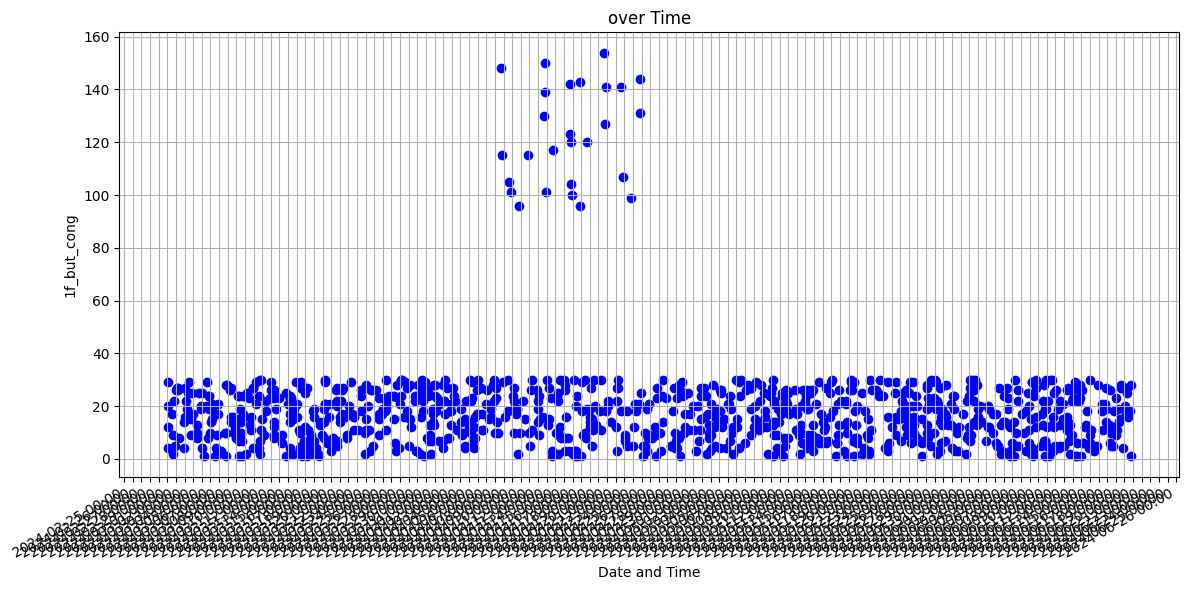

In [ ]:
file_path = '/content/drive/MyDrive/practce/MOCK_DATA.csv'  # 실제 파일 경로로 변경 필요
df = pd.read_csv(file_path, encoding='cp949')

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%m/%d/%Y %H:%M')

# 인덱스를 datetime으로 설정
df.set_index('datetime', inplace=True)

plt.figure(figsize=(12, 6))

# 시계열 데이터 플롯
plt.scatter(df.index, df['1f_but_cong'], marker='o', linestyle='-', color='b')

# 제목 및 축 레이블 설정
plt.title('over Time')
plt.xlabel('Date and Time')
plt.ylabel('1f_but_cong')

# 날짜 형식 조정 및 레이아웃 설정
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()  # 날짜 레이블 회전

plt.grid(True)
plt.tight_layout()

plt.show()